In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

from datetime import timedelta
from notebook_utils import NotebookUtilities
from pandas import DataFrame
import humanize
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re

nu = NotebookUtilities(data_folder_path=os.path.abspath('../data'))

In [3]:

# Get all CSVs into one data frame
if nu.pickle_exists('frvrs_logs_df'):
    frvrs_logs_df = nu.load_object('frvrs_logs_df')
    print(frvrs_logs_df.shape) # (842663, 112)
    # df = frvrs_logs_df.sample(4).dropna(axis='columns', how='all')
    # display(df.T)

(829277, 113)



## Abstract Final Actions


### Median "triage accuracy" across participants as "correctly tagged patients divided by 11"

I'm assuming the denominator here is 11 taggable patients. If not, then it should be the total amount of patients that can be taggable in the scene. So then the definition is as follows: median "triage accuracy" across participants as "correctly tagged patients divided by the total amount of patients that can be treated in the scene". I think it should be 11 given what Nick has been saying and that's also how they do the post-review report.

The average "triage accuracy" across participants is 72.8%
The median number of correct taggings is 8.0.


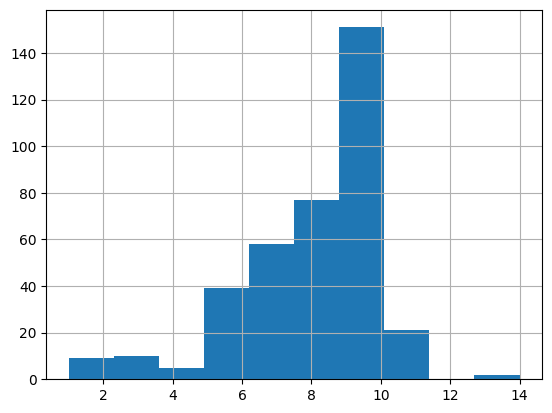

In [21]:

# Filter out the non-aborted triage scenes in each one-per-file file
tag_to_salt_df = nu.load_object('tag_to_salt_df')
base_mask_series = (tag_to_salt_df.scene_type == 'Triage') & (tag_to_salt_df.is_scene_aborted == False) & (tag_to_salt_df.is_a_one_triage_file == True)

scene_groupby_columns = ['session_uuid', 'scene_index']
df = tag_to_salt_df[base_mask_series].groupby(scene_groupby_columns + ['is_tag_correct']).count().patient_id.reset_index(drop=False).rename(
    columns={'patient_id': 'tagged_count'}
)
mask_series = (df.is_tag_correct == True)
ave_triage_accuracy = 100 * df[mask_series].tagged_count.mean() / 11
print(f'The average "triage accuracy" across participants is {ave_triage_accuracy:.01f}%')
print(f'The median number of correct taggings is {df[mask_series].tagged_count.median()}.')
df[mask_series].tagged_count.hist();


1.  **Create new sample with clear count of responders and provide final number of responders here: The total number of responders in this data set was as follows: <u data-renderer-mark="true">362</u>**

    1.  Exclude training session and aborted session CSV files from dataset

    2.  Exclude CSV files with more than one triage run

In [4]:

# Loop through each unique file and scene combination
time_groups_dict = {}
mask_series = (frvrs_logs_df.scene_type == 'Triage') & (frvrs_logs_df.is_scene_aborted == False)
for (file_name), df1 in frvrs_logs_df[mask_series].groupby('file_name'):
    actions_list = []
    
    # Add the scene type for this run
    for (scene_index), df2 in df1.groupby('scene_index'):
        scene_type = df2.scene_type.unique().tolist()
        if len(scene_type) != 1: raise
        else: scene_type = scene_type[0]
        actions_list.append(scene_type)
    
    time_groups_dict[file_name] = actions_list
triage_count_df = pd.DataFrame([{'file_name': k, 'triage_count': v.count('Triage')} for k, v in time_groups_dict.items()])
# display(triage_count_df.groupby('triage_count').size().to_frame().rename(columns={0: 'instances_count'}))

# Infer the number of responders from the files with one triage scene
print('''OSU has cleaned/revised the files. The most common problem was that we previously only had one "Gary" as our training so many of these had a "Gary" and then the triage run. (I am keying on "Mike" to exclude the training sessions.) At any rate, it was easier for them to just delete the "Gary" training session from the files. 

There were a few where OSU could not figure out what was going on, so they just deleted them. It is not worth it to fuss with them since we have plenty of data. (OSU noted these in the spreadsheet.)''')
mask_series = (triage_count_df.triage_count == 1)
responders_list = triage_count_df[mask_series].file_name.tolist()
print(
    '\nExcluding training and aborted runs from the dataset, the total number of responders in this data set after the'
    f' OSU revision of the double-triaged files is now {len(responders_list)}'
    ' (assuming responders are represented in one and only one file with one training run in it).'
)

OSU has cleaned/revised the files. The most common problem was that we previously only had one "Gary" as our training so many of these had a "Gary" and then the triage run. (I am keying on "Mike" to exclude the training sessions.) At any rate, it was easier for them to just delete the "Gary" training session from the files. 

There were a few where OSU could not figure out what was going on, so they just deleted them. It is not worth it to fuss with them since we have plenty of data. (OSU noted these in the spreadsheet.)

Excluding training and aborted runs from the dataset, the total number of responders in this data set after the OSU revision of the double-triaged files is now 389 (assuming responders are represented in one and only one file with one training run in it).


In [5]:

# Store the new feature
new_column_name = 'is_a_one_triage_file'
if (new_column_name not in frvrs_logs_df.columns):
    frvrs_logs_df[new_column_name] = False
    mask_series = frvrs_logs_df.file_name.isin(responders_list)
    frvrs_logs_df.loc[mask_series, new_column_name] = True
    nu.store_objects(frvrs_logs_df=frvrs_logs_df)
    print(frvrs_logs_df.shape) # (842663, 111)
columns_list = ['session_uuid', 'file_name', 'logger_version', 'scene_index', 'scene_type', 'is_scene_aborted', 'is_a_one_triage_file']
display(nu.get_minority_combinations(frvrs_logs_df[columns_list], ['scene_type', 'is_a_one_triage_file']))

,session_uuid,file_name,logger_version,scene_index,scene_type,is_scene_aborted,is_a_one_triage_file
687425,e9632b3b-77f2-4f62-a778-5d6a4242aa3b,v.1.0/Clean e9632b3b-77f2-4f62-a778-5d6a4242aa...,1.0,0,Orientation,False,False
121779,21b0f09b-03b4-4af8-ac65-11ab1e5458d8,All CSV files renamed by date/04.25.23.1403.csv,1.3,0,Orientation,False,True
387593,090d0988-3f81-4603-87e2-477538a6750c,Disaster Day 2022/MT_0950.csv,1.3,1,Triage,False,False
714360,14a344df-eee2-4fd1-b182-e3cdacd9026c,v.1.0/clean-14a344df-eee2-4fd1-b182-e3cdacd902...,1.0,1,Triage,False,True


In [6]:

# Save the time spent on the first and last triage of the files with two scenes to Excel
file_path = '../saves/xlsx/double_runs.xlsx'
if not os.path.exists(file_path):
    mask_series = (triage_count_df.triage_count == 2)
    file_names_list = triage_count_df[mask_series].file_name.tolist()
    mask_series = frvrs_logs_df.file_name.isin(file_names_list) & (frvrs_logs_df.scene_type == 'Triage')
    rows_list = []
    for (file_name), df1 in frvrs_logs_df[mask_series].groupby('file_name'):
        min_triage = df1.scene_index.min()
        mask_series = (frvrs_logs_df.scene_index == min_triage) & (frvrs_logs_df.file_name == file_name)
        df = frvrs_logs_df[mask_series]
        min_start = df.elapsed_time.min()
        min_stop = df.elapsed_time.max()
        min_elapsed = min_stop - min_start
        
        max_triage = df1.scene_index.max()
        mask_series = (frvrs_logs_df.scene_index == max_triage) & (frvrs_logs_df.file_name == file_name)
        df = frvrs_logs_df[mask_series]
        max_start = df.elapsed_time.min()
        max_stop = df.elapsed_time.max()
        max_elapsed = max_stop - max_start
    
        row_dict = {}
        row_dict['file_name'] = file_name
        row_dict['min_elapsed'] = min_elapsed
        row_dict['max_elapsed'] = max_elapsed
        rows_list.append(row_dict)
    df = DataFrame(rows_list)
    df['elapsed_diff'] = df.max_elapsed - df.min_elapsed
    df.file_name = df.file_name.map(lambda x: fu.get_new_file_name(x))
    
    # Save the DataFrame to an Excel file with the index
    df.sort_values('elapsed_diff').set_index('file_name').applymap(
        lambda x: fu.format_timedelta(timedelta(milliseconds=int(x))), na_action='ignore'
    ).to_excel(file_path, index=True)


2.  **Take the newly created data set and compute the following statistics:**


    a.  Calculate triage time defined as “time start of session until time end of session”

        Median = 7:38, SD = ±2:27, IQR = (6:13, 8:59)

In [7]:

# Get the run's entire history
mask_series = (frvrs_logs_df.scene_type == 'Triage') & (frvrs_logs_df.is_scene_aborted == False) & (frvrs_logs_df.is_a_one_triage_file == True)
groupby_columns = ['session_uuid', 'scene_index']
rows_list = []
for (session_uuid, scene_index), df1 in frvrs_logs_df[mask_series].groupby(groupby_columns):
    row_dict = {}
    for cn in groupby_columns: row_dict[cn] = eval(cn)
    time_start = df1.elapsed_time.min()
    row_dict['time_start'] = time_start
    time_stop = df1.elapsed_time.max()
    row_dict['time_stop'] = time_stop
    row_dict['triage_time'] = time_stop - time_start
    rows_list.append(row_dict)
run_time_df = DataFrame(rows_list)
fu.show_time_statistics(run_time_df, ['triage_time'])

,mean,mode,median,SD,min,25%,50%,75%,max
triage_time,7:36,10:22,7:38,±2:27,11 sec,6:13,7:38,8:59,15:52



    b.  Calculate time to hemorrhage control for scene defined as “time of start scene to time last hemorrhage control (last tourniquet applied)”

        Median = 3:51, SD = ±1:44, IQR = (2:41, 4:52)

In [8]:

tool_columns_list = [
    'tool_applied_attachment_point', 'tool_applied_tool_location', 'tool_applied_data', 'tool_applied_sender', 'tool_applied_attach_message', 'tool_applied_patient_id'
]
print(tool_columns_list)
frvrs_logs_df[tool_columns_list].drop_duplicates()

['tool_applied_attachment_point', 'tool_applied_tool_location', 'tool_applied_data', 'tool_applied_sender', 'tool_applied_attach_message', 'tool_applied_patient_id']


,tool_applied_attachment_point,tool_applied_tool_location,tool_applied_data,tool_applied_sender,tool_applied_attach_message,tool_applied_patient_id
0,NaN,NaN,NaN,NaN,NaN,NaN
51,RChest_Breathe1 (UnityEngine.GameObject),cath_needle (UnityEngine.GameObject),right_chest,Needle_Decomp(Clone) (UnityEngine.GameObject),AppliedDecompNeedle,NaN
111,LeftUpLeg (UnityEngine.GameObject),tor_ring (1) (UnityEngine.GameObject),tourniquet(Clone) (UnityEngine.GameObject),AppliedTourniquet,NaN,Mike_1 Root
170,skinCollider_BodyCollideLOD (UnityEngine.GameO...,NaN,NaN,AppliedPackingGauze,NaN,Mike_2 Root
211,skinCollider_BodyCollideLOD (UnityEngine.GameO...,NaN,NaN,AppliedDressingGauze,NaN,Mike_0 Root
...,...,...,...,...,...,...
826348,skinCollider_BodyNudeLOD (UnityEngine.GameObject),null,null,AppliedPackingGauze,NaN,Bob_10 Root
826474,skinCollider_BodyNudeLOD (UnityEngine.GameObject),null,null,AppliedPackingGauze,NaN,Bob_1 Root
826856,RightUpLeg (UnityEngine.GameObject),tor_ring (1) (UnityEngine.GameObject),tourniquet(Clone) (UnityEngine.GameObject),AppliedTourniquet,NaN,Helga_6 Root
827747,RightArm (UnityEngine.GameObject),tor_ring (1) (UnityEngine.GameObject),tourniquet(Clone) (UnityEngine.GameObject),AppliedTourniquet,NaN,Military Mike Jungle Burned_0 Root


In [9]:

injury_columns_list = [
    'injury_record_injury_treated', 'injury_record_injury_treated_with_wrong_treatment', 'injury_treated_injury_treated',
    'injury_treated_injury_treated_with_wrong_treatment'
]#[cn for cn in frvrs_logs_df.columns if 'injury' in cn]
print(injury_columns_list)
frvrs_logs_df[injury_columns_list].drop_duplicates()

['injury_record_injury_treated', 'injury_record_injury_treated_with_wrong_treatment', 'injury_treated_injury_treated', 'injury_treated_injury_treated_with_wrong_treatment']


,injury_record_injury_treated,injury_record_injury_treated_with_wrong_treatment,injury_treated_injury_treated,injury_treated_injury_treated_with_wrong_treatment
0,NaN,NaN,NaN,NaN
6,False,False,NaN,NaN
50,NaN,NaN,True,False
528,NaN,NaN,False,True
533,NaN,NaN,True,True


In [10]:

columns_list = [cn for cn in frvrs_logs_df.columns if ('injury' in cn) and cn.endswith('_id')]
print(columns_list)
frvrs_logs_df[columns_list].drop_duplicates()

['injury_record_id', 'injury_record_patient_id', 'injury_treated_id', 'injury_treated_patient_id', 'injury_id']


,injury_record_id,injury_record_patient_id,injury_treated_id,injury_treated_patient_id,injury_id
0,NaN,NaN,NaN,NaN,NaN
6,R Chest Collapse,Mike_3 Root,NaN,NaN,R Chest Collapse
8,L Shoulder Puncture,Mike_2 Root,NaN,NaN,L Shoulder Puncture
10,L Thigh Laceration,Mike_1 Root,NaN,NaN,L Thigh Laceration
12,R Forearm Laceration,Mike_0 Root,NaN,NaN,R Forearm Laceration
...,...,...,...,...,...
825921,NaN,NaN,R Side Puncture,Lily_5 Root,R Side Puncture
825988,NaN,NaN,R Thigh Laceration,Lily_5 Root,R Thigh Laceration
826099,NaN,NaN,L Bicep Puncture,Lily_11 Root,L Bicep Puncture
826128,NaN,NaN,L Forearm Laceration,Lily_11 Root,L Forearm Laceration


In [12]:

# Get the total and bleeder scene count
base_mask_series = (frvrs_logs_df.scene_type == 'Triage') & (frvrs_logs_df.is_scene_aborted == False) & (frvrs_logs_df.is_a_one_triage_file == True)
mask_series = base_mask_series & frvrs_logs_df.injury_treated_required_procedure.isin(['tourniquet', 'woundpack'])
groupby_columns = ['session_uuid', 'scene_index']
total_scene_count = len(frvrs_logs_df[base_mask_series].groupby(groupby_columns).groups)
gb = frvrs_logs_df[mask_series].groupby(groupby_columns)
bleeder_scene_count = len(gb.groups)

# Iterate through each patient in each run in each file
rows_list = []
file_names_set = set()
for (session_uuid, scene_index), injury_treated_df in gb:
    row_dict = {}
    for cn in groupby_columns: row_dict[cn] = eval(cn)
    
    # Get the entire history of this scene for the run start
    mask_series = True
    for cn in groupby_columns: mask_series &= (frvrs_logs_df[cn] == eval(cn))
    scene_df = frvrs_logs_df[mask_series]
    time_start = scene_df.elapsed_time.min()
    row_dict['scene_start'] = time_start
    
    for patient_id, patient_df in scene_df.groupby('patient_id'):
        row_dict['patient_id'] = patient_id
        
        # Is this patient bleeding?
        bleeding_mask_series = patient_df.injury_treated_required_procedure.isin(['tourniquet', 'woundpack'])
        if patient_df[bleeding_mask_series].shape[0]:
            row_dict['is_patient_bleeding'] = True
            
            # Get the time of patient engagement
            mask_series = patient_df.action_type.isin(['PATIENT_ENGAGED'])
            patient_engaged = patient_df[mask_series].elapsed_time.min()
            row_dict['patient_engagement_time'] = patient_engaged
            
            # Get the entire history of the patients that had these injuries
            injury_mask_series = True
            for cn in groupby_columns: injury_mask_series &= (frvrs_logs_df[cn] == eval(cn))
            injury_mask_series &= (
                (frvrs_logs_df.injury_record_patient_id == patient_id) |
                (frvrs_logs_df.injury_treated_patient_id == patient_id) |
                (frvrs_logs_df.tool_applied_patient_id == patient_id)
            )
            
            # Add the entire history of these injuries
            injury_ids_list = patient_df[bleeding_mask_series].injury_treated_id.tolist()
            injury_mask_series &= (
                frvrs_logs_df.injury_record_id.isin(injury_ids_list) |
                frvrs_logs_df.injury_treated_id.isin(injury_ids_list) |
                frvrs_logs_df.injury_id.isnull()
            )
            # injury_mask_series &= frvrs_logs_df.action_type.isin(['INJURY_RECORD', 'TOOL_APPLIED', 'INJURY_TREATED'])
            
            injury_records_df = frvrs_logs_df[injury_mask_series]

            # Was the correct tool applied?
            mask_series = injury_records_df.tool_applied_sender.isin(['AppliedTourniquet', 'AppliedPackingGauze'])
            if injury_records_df[mask_series].shape[0]:
                row_dict['is_correct_tool_applied'] = True
                
                # Get the last tourniquet applied
                time_stop = injury_records_df[mask_series].elapsed_time.max()
                row_dict['tool_applied_time'] = time_stop
                
                # Get the time elapsed
                row_dict['run_tool_control_time'] = time_stop - time_start
                row_dict['engaged_tool_control_time'] = time_stop - patient_engaged
            
            else: row_dict['is_correct_tool_applied'] = False
            
            # Was the bleeding treated?
            mask_series = (injury_records_df.injury_treated_injury_treated == True) & (injury_records_df.injury_treated_injury_treated_with_wrong_treatment == False)
            if injury_records_df[mask_series].shape[0]:
                row_dict['is_bleeding_treated'] = True
                
                # Get the last tourniquet applied
                time_stop = injury_records_df[mask_series].elapsed_time.max()
                row_dict['bleeding_treated_time'] = time_stop
                
                # Get the time elapsed
                row_dict['run_bleeding_control_time'] = time_stop - time_start
                row_dict['engaged_bleeding_control_time'] = time_stop - patient_engaged
            
            elif (row_dict['is_correct_tool_applied'] == True): 
                columns_list = ['injury_treated_injury_treated', 'tool_applied_sender']
                idx_list = injury_records_df[columns_list].drop_duplicates().index.tolist()
                mask_series = frvrs_logs_df.index.isin(idx_list)
                columns_list = sorted([
                    'injury_treated_required_procedure', 'injury_record_patient_id', 'injury_treated_patient_id', 'tool_applied_patient_id', 'injury_record_id',
                    'injury_treated_id', 'tool_applied_sender', 'injury_treated_injury_treated', 'injury_treated_injury_treated_with_wrong_treatment', 'elapsed_time',
                    'action_type', 'file_name'
                ])
                df = frvrs_logs_df[mask_series][columns_list].sort_values('elapsed_time')
                if (df.tool_applied_sender.unique().shape[0] > 1): display(df.T)
                for file_name in df.file_name: file_names_set.add(file_name)
            #     raise
            else: row_dict['is_bleeding_treated'] = False
        
        else:
            row_dict['is_patient_bleeding'] = False
            row_dict['is_correct_tool_applied'] = False
            row_dict['is_bleeding_treated'] = False
    
    rows_list.append(row_dict)
run_control_time_df = DataFrame(rows_list)

,785,875,876,896,929,930
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,232056,284930,284930,291579,306314,306315
file_name,All CSV files renamed by date/03.10.23.0814.csv,All CSV files renamed by date/03.10.23.0814.csv,All CSV files renamed by date/03.10.23.0814.csv,All CSV files renamed by date/03.10.23.0814.csv,All CSV files renamed by date/03.10.23.0814.csv,All CSV files renamed by date/03.10.23.0814.csv
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,NaN,L Thigh Puncture,NaN
injury_treated_injury_treated,NaN,False,NaN,NaN,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,NaN,True,NaN
injury_treated_patient_id,NaN,Mike_7 Root,NaN,NaN,Mike_7 Root,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,NaN,tourniquet,NaN


,229887,230195,230196,230218,230219
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,19447,211276,211276,222197,222198
file_name,Disaster Day 2022/CH_1115.csv,Disaster Day 2022/CH_1115.csv,Disaster Day 2022/CH_1115.csv,Disaster Day 2022/CH_1115.csv,Disaster Day 2022/CH_1115.csv
injury_record_id,L Side Puncture,NaN,NaN,NaN,NaN
injury_record_patient_id,Lily_4 Root,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Side Puncture,NaN,L Side Puncture,NaN
injury_treated_injury_treated,NaN,False,NaN,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,True,NaN
injury_treated_patient_id,NaN,Lily_4 Root,NaN,Lily_4 Root,NaN
injury_treated_required_procedure,NaN,woundpack,NaN,woundpack,NaN


,657601,658264,658265,658274
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,TOOL_APPLIED
elapsed_time,363601,907284,907284,912507
file_name,Double runs removed/22.03.16.1215r.csv,Double runs removed/22.03.16.1215r.csv,Double runs removed/22.03.16.1215r.csv,Double runs removed/22.03.16.1215r.csv
injury_record_id,R Calf Shrapnel,NaN,NaN,NaN
injury_record_patient_id,Gloria_6 Root,NaN,NaN,NaN
injury_treated_id,NaN,R Calf Shrapnel,NaN,NaN
injury_treated_injury_treated,NaN,False,NaN,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,NaN
injury_treated_patient_id,NaN,Gloria_6 Root,NaN,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,NaN


,141231,141021,141022,141034,141035,141056
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED,TOOL_APPLIED
elapsed_time,28492,210731,210731,215896,215896,228499
file_name,All CSV files renamed by date/12.06.22.1343.csv,All CSV files renamed by date/12.06.22.1343.csv,All CSV files renamed by date/12.06.22.1343.csv,All CSV files renamed by date/12.06.22.1343.csv,All CSV files renamed by date/12.06.22.1343.csv,All CSV files renamed by date/12.06.22.1343.csv
injury_record_id,R Bicep Puncture,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Lily_1 Root,NaN,NaN,NaN,NaN,NaN
injury_treated_id,NaN,R Thigh Laceration,NaN,R Thigh Laceration,NaN,NaN
injury_treated_injury_treated,NaN,False,NaN,True,NaN,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,True,NaN,NaN
injury_treated_patient_id,NaN,Lily_1 Root,NaN,Lily_1 Root,NaN,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,tourniquet,NaN,NaN


,643466,643623,643728,644298,644299
action_type,INJURY_RECORD,TOOL_APPLIED,INJURY_TREATED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,178131,262450,270780,553965,553966
file_name,Double runs removed/22.03.15.1315r.csv,Double runs removed/22.03.15.1315r.csv,Double runs removed/22.03.15.1315r.csv,Double runs removed/22.03.15.1315r.csv,Double runs removed/22.03.15.1315r.csv
injury_record_id,L Side Puncture,NaN,NaN,NaN,NaN
injury_record_patient_id,Lily_4 Root,NaN,NaN,NaN,NaN
injury_treated_id,NaN,NaN,L Side Puncture,L Side Puncture,NaN
injury_treated_injury_treated,NaN,NaN,False,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,NaN,True,True,NaN
injury_treated_patient_id,NaN,NaN,Lily_4 Root,Lily_4 Root,NaN
injury_treated_required_procedure,NaN,NaN,woundpack,woundpack,NaN


,643457,643877,643910,644015,644032,644033
action_type,INJURY_RECORD,TOOL_APPLIED,TOOL_APPLIED,INJURY_TREATED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,178131,329767,333663,344666,351565,351567
file_name,Double runs removed/22.03.15.1315r.csv,Double runs removed/22.03.15.1315r.csv,Double runs removed/22.03.15.1315r.csv,Double runs removed/22.03.15.1315r.csv,Double runs removed/22.03.15.1315r.csv,Double runs removed/22.03.15.1315r.csv
injury_record_id,R Side Puncture,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_5 Root,NaN,NaN,NaN,NaN,NaN
injury_treated_id,NaN,NaN,NaN,R Side Puncture,R Side Puncture,NaN
injury_treated_injury_treated,NaN,NaN,NaN,False,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,NaN,NaN,True,True,NaN
injury_treated_patient_id,NaN,NaN,NaN,Mike_5 Root,Mike_5 Root,NaN
injury_treated_required_procedure,NaN,NaN,NaN,woundpack,woundpack,NaN


,304194,303987,304031,304051,304052
action_type,INJURY_RECORD,TOOL_APPLIED,TOOL_APPLIED,TOOL_APPLIED,INJURY_TREATED
elapsed_time,37140,254393,266685,278536,278536
file_name,Disaster Day 2022/JS_321.csv,Disaster Day 2022/JS_321.csv,Disaster Day 2022/JS_321.csv,Disaster Day 2022/JS_321.csv,Disaster Day 2022/JS_321.csv
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN
injury_treated_id,NaN,NaN,NaN,NaN,L Thigh Puncture
injury_treated_injury_treated,NaN,NaN,NaN,NaN,False
injury_treated_injury_treated_with_wrong_treatment,NaN,NaN,NaN,NaN,True
injury_treated_patient_id,NaN,NaN,NaN,NaN,Mike_7 Root
injury_treated_required_procedure,NaN,NaN,NaN,NaN,tourniquet


,96101,96661,96662,96672,96679,96680
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,405933,629253,629253,639461,647663,647663
file_name,All CSV files renamed by date/04.20.23.1147.csv,All CSV files renamed by date/04.20.23.1147.csv,All CSV files renamed by date/04.20.23.1147.csv,All CSV files renamed by date/04.20.23.1147.csv,All CSV files renamed by date/04.20.23.1147.csv,All CSV files renamed by date/04.20.23.1147.csv
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,NaN,L Thigh Puncture,NaN
injury_treated_injury_treated,NaN,False,NaN,NaN,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,NaN,True,NaN
injury_treated_patient_id,NaN,Mike_7 Root,NaN,NaN,Mike_7 Root,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,NaN,tourniquet,NaN


,373213,373825,373826,374996,374997
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,12475,206286,206286,570488,570491
file_name,Disaster Day 2022/ML_903.csv,Disaster Day 2022/ML_903.csv,Disaster Day 2022/ML_903.csv,Disaster Day 2022/ML_903.csv,Disaster Day 2022/ML_903.csv
injury_record_id,L Side Puncture,NaN,NaN,NaN,NaN
injury_record_patient_id,Lily_4 Root,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Side Puncture,NaN,L Side Puncture,NaN
injury_treated_injury_treated,NaN,False,NaN,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,True,NaN
injury_treated_patient_id,NaN,Lily_4 Root,NaN,Lily_4 Root,NaN
injury_treated_required_procedure,NaN,woundpack,NaN,woundpack,NaN


,73690,74135,74136,74157,74158,74169
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED,TOOL_APPLIED
elapsed_time,414089,648817,648817,653746,653746,658004
file_name,All CSV files renamed by date/04.19.23.1207.csv,All CSV files renamed by date/04.19.23.1207.csv,All CSV files renamed by date/04.19.23.1207.csv,All CSV files renamed by date/04.19.23.1207.csv,All CSV files renamed by date/04.19.23.1207.csv,All CSV files renamed by date/04.19.23.1207.csv
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,L Thigh Puncture,NaN,NaN
injury_treated_injury_treated,NaN,False,NaN,True,NaN,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,True,NaN,NaN
injury_treated_patient_id,NaN,Mike_7 Root,NaN,Mike_7 Root,NaN,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,tourniquet,NaN,NaN


,148311,148492,148493,148520,148521
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,32193,107024,107024,114305,114305
file_name,All CSV files renamed by date/12.07.22.1249.csv,All CSV files renamed by date/12.07.22.1249.csv,All CSV files renamed by date/12.07.22.1249.csv,All CSV files renamed by date/12.07.22.1249.csv,All CSV files renamed by date/12.07.22.1249.csv
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_9 Root,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,L Thigh Puncture,NaN
injury_treated_injury_treated,NaN,False,NaN,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,True,NaN
injury_treated_patient_id,NaN,Mike_9 Root,NaN,Mike_9 Root,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,tourniquet,NaN


,691649,691820,691821,691874,691875,691882
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED,TOOL_APPLIED
elapsed_time,189167,316102,316102,321206,321206,324578
file_name,v.1.0/Clean Marty11.csv,v.1.0/Clean Marty11.csv,v.1.0/Clean Marty11.csv,v.1.0/Clean Marty11.csv,v.1.0/Clean Marty11.csv,v.1.0/Clean Marty11.csv
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,L Thigh Puncture,NaN,NaN
injury_treated_injury_treated,NaN,False,NaN,True,NaN,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,True,NaN,NaN
injury_treated_patient_id,NaN,Mike_7 Root,NaN,Mike_7 Root,NaN,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,tourniquet,NaN,NaN


,211370,212093,212094,212113,212114,212147
action_type,INJURY_RECORD,TOOL_APPLIED,INJURY_TREATED,INJURY_TREATED,TOOL_APPLIED,TOOL_APPLIED
elapsed_time,475136,735348,735348,740714,740714,756274
file_name,DCEMS Round 2 only triage sessions/Heather M.csv,DCEMS Round 2 only triage sessions/Heather M.csv,DCEMS Round 2 only triage sessions/Heather M.csv,DCEMS Round 2 only triage sessions/Heather M.csv,DCEMS Round 2 only triage sessions/Heather M.csv,DCEMS Round 2 only triage sessions/Heather M.csv
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN,NaN
injury_treated_id,NaN,NaN,L Thigh Puncture,L Thigh Puncture,NaN,NaN
injury_treated_injury_treated,NaN,NaN,False,True,NaN,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,NaN,True,True,NaN,NaN
injury_treated_patient_id,NaN,NaN,Mike_7 Root,Mike_7 Root,NaN,NaN
injury_treated_required_procedure,NaN,NaN,tourniquet,tourniquet,NaN,NaN


,1844,2272,2273,2279,2280
action_type,INJURY_RECORD,TOOL_APPLIED,INJURY_TREATED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,643073,877585,877585,880758,880758
file_name,All CSV files renamed by date/03.10.23.0831.csv,All CSV files renamed by date/03.10.23.0831.csv,All CSV files renamed by date/03.10.23.0831.csv,All CSV files renamed by date/03.10.23.0831.csv,All CSV files renamed by date/03.10.23.0831.csv
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN
injury_treated_id,NaN,NaN,L Thigh Puncture,L Thigh Puncture,NaN
injury_treated_injury_treated,NaN,NaN,False,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,NaN,True,True,NaN
injury_treated_patient_id,NaN,NaN,Mike_7 Root,Mike_7 Root,NaN
injury_treated_required_procedure,NaN,NaN,tourniquet,tourniquet,NaN


,156522,155634,155635,155674,155675
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,42465,118568,118569,122438,122438
file_name,All CSV files renamed by date/12.09.22.1325.csv,All CSV files renamed by date/12.09.22.1325.csv,All CSV files renamed by date/12.09.22.1325.csv,All CSV files renamed by date/12.09.22.1325.csv,All CSV files renamed by date/12.09.22.1325.csv
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_9 Root,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,L Thigh Puncture,NaN
injury_treated_injury_treated,NaN,False,NaN,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,True,NaN
injury_treated_patient_id,NaN,Mike_9 Root,NaN,Mike_9 Root,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,tourniquet,NaN


,671278,671507,671508,671530,671559,671574
action_type,INJURY_RECORD,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,505843,704440,704440,712289,716372,725829
file_name,v.1.0/Clean 47bb9911-6096-4703-8551-4a0f8cb106...,v.1.0/Clean 47bb9911-6096-4703-8551-4a0f8cb106...,v.1.0/Clean 47bb9911-6096-4703-8551-4a0f8cb106...,v.1.0/Clean 47bb9911-6096-4703-8551-4a0f8cb106...,v.1.0/Clean 47bb9911-6096-4703-8551-4a0f8cb106...,v.1.0/Clean 47bb9911-6096-4703-8551-4a0f8cb106...
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN,NaN
injury_treated_id,NaN,NaN,L Thigh Puncture,NaN,L Thigh Puncture,NaN
injury_treated_injury_treated,NaN,NaN,False,NaN,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,NaN,True,NaN,True,NaN
injury_treated_patient_id,NaN,NaN,Mike_7 Root,NaN,Mike_7 Root,NaN
injury_treated_required_procedure,NaN,NaN,tourniquet,NaN,tourniquet,NaN


,671995,672142,672143,672182,672183
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,44387,136790,136790,141746,141746
file_name,v.1.0/Clean 4a219569-77fc-41c2-8244-42888b25fe...,v.1.0/Clean 4a219569-77fc-41c2-8244-42888b25fe...,v.1.0/Clean 4a219569-77fc-41c2-8244-42888b25fe...,v.1.0/Clean 4a219569-77fc-41c2-8244-42888b25fe...,v.1.0/Clean 4a219569-77fc-41c2-8244-42888b25fe...
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,L Thigh Puncture,NaN
injury_treated_injury_treated,NaN,False,NaN,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,True,NaN
injury_treated_patient_id,NaN,Mike_7 Root,NaN,Mike_7 Root,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,tourniquet,NaN


,176982,177496,177497,177549,177595,177596
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,48509,327456,327456,332815,342980,342980
file_name,DCEMS Round 2 only triage sessions/4a504e80-02...,DCEMS Round 2 only triage sessions/4a504e80-02...,DCEMS Round 2 only triage sessions/4a504e80-02...,DCEMS Round 2 only triage sessions/4a504e80-02...,DCEMS Round 2 only triage sessions/4a504e80-02...,DCEMS Round 2 only triage sessions/4a504e80-02...
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,NaN,L Thigh Puncture,NaN
injury_treated_injury_treated,NaN,False,NaN,NaN,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,NaN,True,NaN
injury_treated_patient_id,NaN,Mike_7 Root,NaN,NaN,Mike_7 Root,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,NaN,tourniquet,NaN


,703324,703714,703720,703721,703789,703790
action_type,INJURY_RECORD,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,20220,253396,256933,256933,278339,278341
file_name,v.1.0/Clean Marty25.csv,v.1.0/Clean Marty25.csv,v.1.0/Clean Marty25.csv,v.1.0/Clean Marty25.csv,v.1.0/Clean Marty25.csv,v.1.0/Clean Marty25.csv
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN,NaN
injury_treated_id,NaN,NaN,L Thigh Puncture,NaN,L Thigh Puncture,NaN
injury_treated_injury_treated,NaN,NaN,False,NaN,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,NaN,True,NaN,True,NaN
injury_treated_patient_id,NaN,NaN,Mike_7 Root,NaN,Mike_7 Root,NaN
injury_treated_required_procedure,NaN,NaN,tourniquet,NaN,tourniquet,NaN


,727752,728152,728171,728172,728193,728209
action_type,INJURY_RECORD,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED,TOOL_APPLIED,INJURY_TREATED
elapsed_time,232445,447773,454400,454400,463983,468638
file_name,v.1.0/clean-52e2653e-2230-4d8a-929b-e2a12dcb56...,v.1.0/clean-52e2653e-2230-4d8a-929b-e2a12dcb56...,v.1.0/clean-52e2653e-2230-4d8a-929b-e2a12dcb56...,v.1.0/clean-52e2653e-2230-4d8a-929b-e2a12dcb56...,v.1.0/clean-52e2653e-2230-4d8a-929b-e2a12dcb56...,v.1.0/clean-52e2653e-2230-4d8a-929b-e2a12dcb56...
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN,NaN
injury_treated_id,NaN,NaN,L Thigh Puncture,NaN,NaN,L Thigh Puncture
injury_treated_injury_treated,NaN,NaN,False,NaN,NaN,True
injury_treated_injury_treated_with_wrong_treatment,NaN,NaN,True,NaN,NaN,True
injury_treated_patient_id,NaN,NaN,Mike_7 Root,NaN,NaN,Mike_7 Root
injury_treated_required_procedure,NaN,NaN,tourniquet,NaN,NaN,tourniquet


,221357,221500,221501,221515,221516
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,33336,101961,101961,105179,105179
file_name,DCEMS Round 2 only triage sessions/Kami P.csv,DCEMS Round 2 only triage sessions/Kami P.csv,DCEMS Round 2 only triage sessions/Kami P.csv,DCEMS Round 2 only triage sessions/Kami P.csv,DCEMS Round 2 only triage sessions/Kami P.csv
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,L Thigh Puncture,NaN
injury_treated_injury_treated,NaN,False,NaN,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,True,NaN
injury_treated_patient_id,NaN,Mike_7 Root,NaN,Mike_7 Root,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,tourniquet,NaN


,706428,706567,706568,706588,706589,706595
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED,TOOL_APPLIED
elapsed_time,270587,415837,415837,419594,419594,425891
file_name,v.1.0/Clean Marty4.csv,v.1.0/Clean Marty4.csv,v.1.0/Clean Marty4.csv,v.1.0/Clean Marty4.csv,v.1.0/Clean Marty4.csv,v.1.0/Clean Marty4.csv
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,L Thigh Puncture,NaN,NaN
injury_treated_injury_treated,NaN,False,NaN,True,NaN,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,True,NaN,NaN
injury_treated_patient_id,NaN,Mike_7 Root,NaN,Mike_7 Root,NaN,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,tourniquet,NaN,NaN


,634155,634434,634443,634444
action_type,INJURY_RECORD,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,140512,323132,329435,329435
file_name,Double runs removed/22.03.15.0844r.csv,Double runs removed/22.03.15.0844r.csv,Double runs removed/22.03.15.0844r.csv,Double runs removed/22.03.15.0844r.csv
injury_record_id,R Side Puncture,NaN,NaN,NaN
injury_record_patient_id,Mike_5 Root,NaN,NaN,NaN
injury_treated_id,NaN,NaN,R Side Puncture,NaN
injury_treated_injury_treated,NaN,NaN,False,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,NaN,True,NaN
injury_treated_patient_id,NaN,NaN,Mike_5 Root,NaN
injury_treated_required_procedure,NaN,NaN,woundpack,NaN


,178271,178549,178550,178554,178555
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,24114,190270,190270,193087,193087
file_name,DCEMS Round 2 only triage sessions/5e1e1072-22...,DCEMS Round 2 only triage sessions/5e1e1072-22...,DCEMS Round 2 only triage sessions/5e1e1072-22...,DCEMS Round 2 only triage sessions/5e1e1072-22...,DCEMS Round 2 only triage sessions/5e1e1072-22...
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,L Thigh Puncture,NaN
injury_treated_injury_treated,NaN,False,NaN,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,True,NaN
injury_treated_patient_id,NaN,Mike_7 Root,NaN,Mike_7 Root,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,tourniquet,NaN


,146017,146274,146275,146284,146285
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,15274,174308,174308,177866,177866
file_name,All CSV files renamed by date/12.07.22.1031.csv,All CSV files renamed by date/12.07.22.1031.csv,All CSV files renamed by date/12.07.22.1031.csv,All CSV files renamed by date/12.07.22.1031.csv,All CSV files renamed by date/12.07.22.1031.csv
injury_record_id,R Thigh Laceration,NaN,NaN,NaN,NaN
injury_record_patient_id,Lily_1 Root,NaN,NaN,NaN,NaN
injury_treated_id,NaN,R Thigh Laceration,NaN,R Thigh Laceration,NaN
injury_treated_injury_treated,NaN,False,NaN,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,True,NaN
injury_treated_patient_id,NaN,Lily_1 Root,NaN,Lily_1 Root,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,tourniquet,NaN


,146000,146121,146122,146168,146169
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,15274,83125,83125,89305,89305
file_name,All CSV files renamed by date/12.07.22.1031.csv,All CSV files renamed by date/12.07.22.1031.csv,All CSV files renamed by date/12.07.22.1031.csv,All CSV files renamed by date/12.07.22.1031.csv,All CSV files renamed by date/12.07.22.1031.csv
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_9 Root,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,L Thigh Puncture,NaN
injury_treated_injury_treated,NaN,False,NaN,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,True,NaN
injury_treated_patient_id,NaN,Mike_9 Root,NaN,Mike_9 Root,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,tourniquet,NaN


,134074,134127,134128,134188
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,TOOL_APPLIED
elapsed_time,26933,301713,301714,414589
file_name,All CSV files renamed by date/12.01.22.1315.csv,All CSV files renamed by date/12.01.22.1315.csv,All CSV files renamed by date/12.01.22.1315.csv,All CSV files renamed by date/12.01.22.1315.csv
injury_record_id,L Thigh Puncture,NaN,NaN,NaN
injury_record_patient_id,Helga_0 Root,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,NaN
injury_treated_injury_treated,NaN,False,NaN,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,NaN
injury_treated_patient_id,NaN,Helga_0 Root,NaN,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,NaN


,134078,133966,133967,133987,133996,134009
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,TOOL_APPLIED,TOOL_APPLIED,INJURY_TREATED
elapsed_time,26933,213549,213549,218029,226615,232796
file_name,All CSV files renamed by date/12.01.22.1315.csv,All CSV files renamed by date/12.01.22.1315.csv,All CSV files renamed by date/12.01.22.1315.csv,All CSV files renamed by date/12.01.22.1315.csv,All CSV files renamed by date/12.01.22.1315.csv,All CSV files renamed by date/12.01.22.1315.csv
injury_record_id,R Thigh Laceration,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Lily_1 Root,NaN,NaN,NaN,NaN,NaN
injury_treated_id,NaN,R Thigh Laceration,NaN,NaN,NaN,R Thigh Laceration
injury_treated_injury_treated,NaN,False,NaN,NaN,NaN,True
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,NaN,NaN,True
injury_treated_patient_id,NaN,Lily_1 Root,NaN,NaN,NaN,Lily_1 Root
injury_treated_required_procedure,NaN,tourniquet,NaN,NaN,NaN,tourniquet


,134083,133856,133857,133878,133879
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,26934,150420,150420,158569,158569
file_name,All CSV files renamed by date/12.01.22.1315.csv,All CSV files renamed by date/12.01.22.1315.csv,All CSV files renamed by date/12.01.22.1315.csv,All CSV files renamed by date/12.01.22.1315.csv,All CSV files renamed by date/12.01.22.1315.csv
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_9 Root,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,L Thigh Puncture,NaN
injury_treated_injury_treated,NaN,False,NaN,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,True,NaN
injury_treated_patient_id,NaN,Mike_9 Root,NaN,Mike_9 Root,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,tourniquet,NaN


,84142,84341,84346,84347,84351,84352
action_type,INJURY_RECORD,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,279002,438893,443237,443237,447363,447364
file_name,All CSV files renamed by date/04.20.23.0908.csv,All CSV files renamed by date/04.20.23.0908.csv,All CSV files renamed by date/04.20.23.0908.csv,All CSV files renamed by date/04.20.23.0908.csv,All CSV files renamed by date/04.20.23.0908.csv,All CSV files renamed by date/04.20.23.0908.csv
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN,NaN
injury_treated_id,NaN,NaN,L Thigh Puncture,NaN,L Thigh Puncture,NaN
injury_treated_injury_treated,NaN,NaN,False,NaN,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,NaN,True,NaN,True,NaN
injury_treated_patient_id,NaN,NaN,Mike_7 Root,NaN,Mike_7 Root,NaN
injury_treated_required_procedure,NaN,NaN,tourniquet,NaN,tourniquet,NaN


,641566,642571,642575,642576,642683
action_type,INJURY_RECORD,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED,TOOL_APPLIED
elapsed_time,441770,921102,925367,925367,950991
file_name,Double runs removed/22.03.15.1131r.csv,Double runs removed/22.03.15.1131r.csv,Double runs removed/22.03.15.1131r.csv,Double runs removed/22.03.15.1131r.csv,Double runs removed/22.03.15.1131r.csv
injury_record_id,R Side Puncture,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_5 Root,NaN,NaN,NaN,NaN
injury_treated_id,NaN,NaN,R Side Puncture,NaN,NaN
injury_treated_injury_treated,NaN,NaN,False,NaN,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,NaN,True,NaN,NaN
injury_treated_patient_id,NaN,NaN,Mike_5 Root,NaN,NaN
injury_treated_required_procedure,NaN,NaN,woundpack,NaN,NaN


,124411,124644,124645,124676,124677,124690
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED,TOOL_APPLIED
elapsed_time,23625,208776,208776,214305,214305,216946
file_name,All CSV files renamed by date/11.30.22.0957.csv,All CSV files renamed by date/11.30.22.0957.csv,All CSV files renamed by date/11.30.22.0957.csv,All CSV files renamed by date/11.30.22.0957.csv,All CSV files renamed by date/11.30.22.0957.csv,All CSV files renamed by date/11.30.22.0957.csv
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Helga_0 Root,NaN,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,L Thigh Puncture,NaN,NaN
injury_treated_injury_treated,NaN,False,NaN,True,NaN,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,True,NaN,NaN
injury_treated_patient_id,NaN,Helga_0 Root,NaN,Helga_0 Root,NaN,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,tourniquet,NaN,NaN


,179250,180032,180053,180054
action_type,INJURY_RECORD,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,38812,756750,769367,769368
file_name,DCEMS Round 2 only triage sessions/684d04c4-83...,DCEMS Round 2 only triage sessions/684d04c4-83...,DCEMS Round 2 only triage sessions/684d04c4-83...,DCEMS Round 2 only triage sessions/684d04c4-83...
injury_record_id,L Side Puncture,NaN,NaN,NaN
injury_record_patient_id,Lily_4 Root,NaN,NaN,NaN
injury_treated_id,NaN,NaN,L Side Puncture,NaN
injury_treated_injury_treated,NaN,NaN,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,NaN,True,NaN
injury_treated_patient_id,NaN,NaN,Lily_4 Root,NaN
injury_treated_required_procedure,NaN,NaN,woundpack,NaN


,180079,180469,180470,180488,180489,180619
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED,TOOL_APPLIED
elapsed_time,26471,247245,247245,251790,251790,303672
file_name,DCEMS Round 2 only triage sessions/68f0ccd0-ec...,DCEMS Round 2 only triage sessions/68f0ccd0-ec...,DCEMS Round 2 only triage sessions/68f0ccd0-ec...,DCEMS Round 2 only triage sessions/68f0ccd0-ec...,DCEMS Round 2 only triage sessions/68f0ccd0-ec...,DCEMS Round 2 only triage sessions/68f0ccd0-ec...
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,L Thigh Puncture,NaN,NaN
injury_treated_injury_treated,NaN,False,NaN,True,NaN,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,True,NaN,NaN
injury_treated_patient_id,NaN,Mike_7 Root,NaN,Mike_7 Root,NaN,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,tourniquet,NaN,NaN


,80224,80598,80599,80628,80648,80649
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,360876,612065,612065,631059,637343,637343
file_name,All CSV files renamed by date/04.19.23.1432.csv,All CSV files renamed by date/04.19.23.1432.csv,All CSV files renamed by date/04.19.23.1432.csv,All CSV files renamed by date/04.19.23.1432.csv,All CSV files renamed by date/04.19.23.1432.csv,All CSV files renamed by date/04.19.23.1432.csv
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,NaN,L Thigh Puncture,NaN
injury_treated_injury_treated,NaN,False,NaN,NaN,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,NaN,True,NaN
injury_treated_patient_id,NaN,Mike_7 Root,NaN,NaN,Mike_7 Root,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,NaN,tourniquet,NaN


,735467,736135,736136,736176,736177
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,393161,672363,672363,679191,679191
file_name,v.1.0/clean-7dacebd5-f16e-4faa-8a00-f738b7d04e...,v.1.0/clean-7dacebd5-f16e-4faa-8a00-f738b7d04e...,v.1.0/clean-7dacebd5-f16e-4faa-8a00-f738b7d04e...,v.1.0/clean-7dacebd5-f16e-4faa-8a00-f738b7d04e...,v.1.0/clean-7dacebd5-f16e-4faa-8a00-f738b7d04e...
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,L Thigh Puncture,NaN
injury_treated_injury_treated,NaN,False,NaN,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,True,NaN
injury_treated_patient_id,NaN,Mike_7 Root,NaN,Mike_7 Root,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,tourniquet,NaN


,736807,737223,737240,737241,737255,737256
action_type,INJURY_RECORD,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,251160,512410,520674,520674,524831,524832
file_name,v.1.0/clean-7de52180-d823-4f9e-9003-aeab813997...,v.1.0/clean-7de52180-d823-4f9e-9003-aeab813997...,v.1.0/clean-7de52180-d823-4f9e-9003-aeab813997...,v.1.0/clean-7de52180-d823-4f9e-9003-aeab813997...,v.1.0/clean-7de52180-d823-4f9e-9003-aeab813997...,v.1.0/clean-7de52180-d823-4f9e-9003-aeab813997...
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN,NaN
injury_treated_id,NaN,NaN,L Thigh Puncture,NaN,L Thigh Puncture,NaN
injury_treated_injury_treated,NaN,NaN,False,NaN,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,NaN,True,NaN,True,NaN
injury_treated_patient_id,NaN,NaN,Mike_7 Root,NaN,Mike_7 Root,NaN
injury_treated_required_procedure,NaN,NaN,tourniquet,NaN,tourniquet,NaN


,145500,145782,145783,145794,145795
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,42422,239674,239674,248327,248327
file_name,All CSV files renamed by date/12.07.22.1011.csv,All CSV files renamed by date/12.07.22.1011.csv,All CSV files renamed by date/12.07.22.1011.csv,All CSV files renamed by date/12.07.22.1011.csv,All CSV files renamed by date/12.07.22.1011.csv
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN
injury_record_patient_id,Helga_0 Root,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,L Thigh Puncture,NaN
injury_treated_injury_treated,NaN,False,NaN,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,True,NaN
injury_treated_patient_id,NaN,Helga_0 Root,NaN,Helga_0 Root,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,tourniquet,NaN


,237560,238266,238304,238305
action_type,INJURY_RECORD,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,17421,63752,82516,82516
file_name,Disaster Day 2022/IP_236.csv,Disaster Day 2022/IP_236.csv,Disaster Day 2022/IP_236.csv,Disaster Day 2022/IP_236.csv
injury_record_id,R Side Puncture,NaN,NaN,NaN
injury_record_patient_id,Mike_5 Root,NaN,NaN,NaN
injury_treated_id,NaN,NaN,R Side Puncture,NaN
injury_treated_injury_treated,NaN,NaN,False,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,NaN,True,NaN
injury_treated_patient_id,NaN,NaN,Mike_5 Root,NaN
injury_treated_required_procedure,NaN,NaN,woundpack,NaN


,743865,744095,744096,744165,744166
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,TOOL_APPLIED,INJURY_TREATED
elapsed_time,276306,406722,406722,425826,425826
file_name,v.1.0/clean-868cbf3b-f04a-4e1a-a207-95881d5293...,v.1.0/clean-868cbf3b-f04a-4e1a-a207-95881d5293...,v.1.0/clean-868cbf3b-f04a-4e1a-a207-95881d5293...,v.1.0/clean-868cbf3b-f04a-4e1a-a207-95881d5293...,v.1.0/clean-868cbf3b-f04a-4e1a-a207-95881d5293...
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,NaN,L Thigh Puncture
injury_treated_injury_treated,NaN,False,NaN,NaN,True
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,NaN,True
injury_treated_patient_id,NaN,Mike_7 Root,NaN,NaN,Mike_7 Root
injury_treated_required_procedure,NaN,tourniquet,NaN,NaN,tourniquet


,791531,792252,792253,792259,792260,792273
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED,TOOL_APPLIED
elapsed_time,272361,516811,516811,521472,521472,526887
file_name,v.1.0/clean-max10.csv,v.1.0/clean-max10.csv,v.1.0/clean-max10.csv,v.1.0/clean-max10.csv,v.1.0/clean-max10.csv,v.1.0/clean-max10.csv
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,L Thigh Puncture,NaN,NaN
injury_treated_injury_treated,NaN,False,NaN,True,NaN,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,True,NaN,NaN
injury_treated_patient_id,NaN,Mike_7 Root,NaN,Mike_7 Root,NaN,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,tourniquet,NaN,NaN


,187046,184705,184706,184742,184743,184799
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED,TOOL_APPLIED
elapsed_time,900652,1123849,1123849,1137875,1137875,1252842
file_name,DCEMS Round 2 only triage sessions/8832990e-c8...,DCEMS Round 2 only triage sessions/8832990e-c8...,DCEMS Round 2 only triage sessions/8832990e-c8...,DCEMS Round 2 only triage sessions/8832990e-c8...,DCEMS Round 2 only triage sessions/8832990e-c8...,DCEMS Round 2 only triage sessions/8832990e-c8...
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,L Thigh Puncture,NaN,NaN
injury_treated_injury_treated,NaN,False,NaN,True,NaN,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,True,NaN,NaN
injury_treated_patient_id,NaN,Mike_7 Root,NaN,Mike_7 Root,NaN,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,tourniquet,NaN,NaN


,753402,753889,753901,753902
action_type,INJURY_RECORD,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,271944,497305,502942,502942
file_name,v.1.0/clean-992d4672-7993-44ba-890c-0d8605ccef...,v.1.0/clean-992d4672-7993-44ba-890c-0d8605ccef...,v.1.0/clean-992d4672-7993-44ba-890c-0d8605ccef...,v.1.0/clean-992d4672-7993-44ba-890c-0d8605ccef...
injury_record_id,L Side Puncture,NaN,NaN,NaN
injury_record_patient_id,Lily_4 Root,NaN,NaN,NaN
injury_treated_id,NaN,NaN,L Side Puncture,NaN
injury_treated_injury_treated,NaN,NaN,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,NaN,True,NaN
injury_treated_patient_id,NaN,NaN,Lily_4 Root,NaN
injury_treated_required_procedure,NaN,NaN,woundpack,NaN


,306277,306588,306627,306628
action_type,INJURY_RECORD,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,17694,362173,365795,365795
file_name,Disaster Day 2022/MG_0208.csv,Disaster Day 2022/MG_0208.csv,Disaster Day 2022/MG_0208.csv,Disaster Day 2022/MG_0208.csv
injury_record_id,R Side Puncture,NaN,NaN,NaN
injury_record_patient_id,Mike_5 Root,NaN,NaN,NaN
injury_treated_id,NaN,NaN,R Side Puncture,NaN
injury_treated_injury_treated,NaN,NaN,False,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,NaN,True,NaN
injury_treated_patient_id,NaN,NaN,Mike_5 Root,NaN
injury_treated_required_procedure,NaN,NaN,woundpack,NaN


,644544,645316,645334,645364,645365
action_type,INJURY_RECORD,TOOL_APPLIED,INJURY_TREATED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,290036,739057,741567,747578,747579
file_name,Double runs removed/22.03.15.1316r.csv,Double runs removed/22.03.15.1316r.csv,Double runs removed/22.03.15.1316r.csv,Double runs removed/22.03.15.1316r.csv,Double runs removed/22.03.15.1316r.csv
injury_record_id,R Shin Amputation,NaN,NaN,NaN,NaN
injury_record_patient_id,Lily_2 Root,NaN,NaN,NaN,NaN
injury_treated_id,NaN,NaN,R Shin Amputation,R Shin Amputation,NaN
injury_treated_injury_treated,NaN,NaN,False,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,NaN,True,True,NaN
injury_treated_patient_id,NaN,NaN,Lily_2 Root,Lily_2 Root,NaN
injury_treated_required_procedure,NaN,NaN,tourniquet,tourniquet,NaN


,644566,645070,645127,645128
action_type,INJURY_RECORD,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,290037,683527,688445,688445
file_name,Double runs removed/22.03.15.1316r.csv,Double runs removed/22.03.15.1316r.csv,Double runs removed/22.03.15.1316r.csv,Double runs removed/22.03.15.1316r.csv
injury_record_id,R Side Puncture,NaN,NaN,NaN
injury_record_patient_id,Mike_5 Root,NaN,NaN,NaN
injury_treated_id,NaN,NaN,R Side Puncture,NaN
injury_treated_injury_treated,NaN,NaN,False,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,NaN,True,NaN
injury_treated_patient_id,NaN,NaN,Mike_5 Root,NaN
injury_treated_required_procedure,NaN,NaN,woundpack,NaN


,765856,766182,766183,766226,766227,766246
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED,TOOL_APPLIED
elapsed_time,227800,450709,450709,463367,463367,472900
file_name,v.1.0/clean-a1cb9dd5-e62b-4085-99d8-688e0a3856...,v.1.0/clean-a1cb9dd5-e62b-4085-99d8-688e0a3856...,v.1.0/clean-a1cb9dd5-e62b-4085-99d8-688e0a3856...,v.1.0/clean-a1cb9dd5-e62b-4085-99d8-688e0a3856...,v.1.0/clean-a1cb9dd5-e62b-4085-99d8-688e0a3856...,v.1.0/clean-a1cb9dd5-e62b-4085-99d8-688e0a3856...
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,L Thigh Puncture,NaN,NaN
injury_treated_injury_treated,NaN,False,NaN,True,NaN,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,True,NaN,NaN
injury_treated_patient_id,NaN,Mike_7 Root,NaN,Mike_7 Root,NaN,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,tourniquet,NaN,NaN


,685225,685391,685392,685406,685407
action_type,INJURY_RECORD,TOOL_APPLIED,INJURY_TREATED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,27149,177138,177138,181391,181391
file_name,v.1.0/Clean a2a38d07-04c7-4b02-839e-83dc10e516...,v.1.0/Clean a2a38d07-04c7-4b02-839e-83dc10e516...,v.1.0/Clean a2a38d07-04c7-4b02-839e-83dc10e516...,v.1.0/Clean a2a38d07-04c7-4b02-839e-83dc10e516...,v.1.0/Clean a2a38d07-04c7-4b02-839e-83dc10e516...
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN
injury_treated_id,NaN,NaN,L Thigh Puncture,L Thigh Puncture,NaN
injury_treated_injury_treated,NaN,NaN,False,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,NaN,True,True,NaN
injury_treated_patient_id,NaN,NaN,Mike_7 Root,Mike_7 Root,NaN
injury_treated_required_procedure,NaN,NaN,tourniquet,tourniquet,NaN


,228091,229408,229409,229451,229452
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,14460,379289,379289,390132,390133
file_name,Disaster Day 2022/BT_919.csv,Disaster Day 2022/BT_919.csv,Disaster Day 2022/BT_919.csv,Disaster Day 2022/BT_919.csv,Disaster Day 2022/BT_919.csv
injury_record_id,L Side Puncture,NaN,NaN,NaN,NaN
injury_record_patient_id,Lily_4 Root,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Side Puncture,NaN,L Side Puncture,NaN
injury_treated_injury_treated,NaN,False,NaN,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,True,NaN
injury_treated_patient_id,NaN,Lily_4 Root,NaN,Lily_4 Root,NaN
injury_treated_required_procedure,NaN,woundpack,NaN,woundpack,NaN


,45399,45688,45689,45697,45698,45716
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED,TOOL_APPLIED
elapsed_time,372203,698497,698497,704789,704789,721301
file_name,All CSV files renamed by date/03.14.23.1502.csv,All CSV files renamed by date/03.14.23.1502.csv,All CSV files renamed by date/03.14.23.1502.csv,All CSV files renamed by date/03.14.23.1502.csv,All CSV files renamed by date/03.14.23.1502.csv,All CSV files renamed by date/03.14.23.1502.csv
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,L Thigh Puncture,NaN,NaN
injury_treated_injury_treated,NaN,False,NaN,True,NaN,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,True,NaN,NaN
injury_treated_patient_id,NaN,Mike_7 Root,NaN,Mike_7 Root,NaN,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,tourniquet,NaN,NaN


,140542,140277,140278,140289,140290
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,26259,115073,115073,120067,120067
file_name,All CSV files renamed by date/12.06.22.1303.csv,All CSV files renamed by date/12.06.22.1303.csv,All CSV files renamed by date/12.06.22.1303.csv,All CSV files renamed by date/12.06.22.1303.csv,All CSV files renamed by date/12.06.22.1303.csv
injury_record_id,R Thigh Laceration,NaN,NaN,NaN,NaN
injury_record_patient_id,Lily_1 Root,NaN,NaN,NaN,NaN
injury_treated_id,NaN,R Thigh Laceration,NaN,R Thigh Laceration,NaN
injury_treated_injury_treated,NaN,False,NaN,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,True,NaN
injury_treated_patient_id,NaN,Lily_1 Root,NaN,Lily_1 Root,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,tourniquet,NaN


,582837,583900,583922,583923,583941
action_type,INJURY_RECORD,TOOL_APPLIED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,14854,342844,374677,374677,379013
file_name,Disaster Day 2022/SL_1155.csv,Disaster Day 2022/SL_1155.csv,Disaster Day 2022/SL_1155.csv,Disaster Day 2022/SL_1155.csv,Disaster Day 2022/SL_1155.csv
injury_record_id,R Calf Shrapnel,NaN,NaN,NaN,NaN
injury_record_patient_id,Gloria_6 Root,NaN,NaN,NaN,NaN
injury_treated_id,NaN,NaN,NaN,R Calf Shrapnel,NaN
injury_treated_injury_treated,NaN,NaN,NaN,False,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,NaN,NaN,True,NaN
injury_treated_patient_id,NaN,NaN,NaN,Gloria_6 Root,NaN
injury_treated_required_procedure,NaN,NaN,NaN,tourniquet,NaN


,767059,767395,767396,767412,767413
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,TOOL_APPLIED,INJURY_TREATED
elapsed_time,404737,614686,614686,618152,618152
file_name,v.1.0/clean-ad2137d0-d5aa-4a4e-af02-e327993c6d...,v.1.0/clean-ad2137d0-d5aa-4a4e-af02-e327993c6d...,v.1.0/clean-ad2137d0-d5aa-4a4e-af02-e327993c6d...,v.1.0/clean-ad2137d0-d5aa-4a4e-af02-e327993c6d...,v.1.0/clean-ad2137d0-d5aa-4a4e-af02-e327993c6d...
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,NaN,L Thigh Puncture
injury_treated_injury_treated,NaN,False,NaN,NaN,True
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,NaN,True
injury_treated_patient_id,NaN,Mike_7 Root,NaN,NaN,Mike_7 Root
injury_treated_required_procedure,NaN,tourniquet,NaN,NaN,tourniquet


,38832,39040,39041,39155,39156,39198
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED,TOOL_APPLIED
elapsed_time,17753,218285,218285,227949,227949,238494
file_name,All CSV files renamed by date/03.14.23.1306.csv,All CSV files renamed by date/03.14.23.1306.csv,All CSV files renamed by date/03.14.23.1306.csv,All CSV files renamed by date/03.14.23.1306.csv,All CSV files renamed by date/03.14.23.1306.csv,All CSV files renamed by date/03.14.23.1306.csv
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,L Thigh Puncture,NaN,NaN
injury_treated_injury_treated,NaN,False,NaN,True,NaN,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,True,NaN,NaN
injury_treated_patient_id,NaN,Mike_7 Root,NaN,Mike_7 Root,NaN,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,tourniquet,NaN,NaN


,53247,53663,53664,53679,53709,53710
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,388061,603224,603224,614937,627522,627523
file_name,All CSV files renamed by date/03.15.23.0851.csv,All CSV files renamed by date/03.15.23.0851.csv,All CSV files renamed by date/03.15.23.0851.csv,All CSV files renamed by date/03.15.23.0851.csv,All CSV files renamed by date/03.15.23.0851.csv,All CSV files renamed by date/03.15.23.0851.csv
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,NaN,L Thigh Puncture,NaN
injury_treated_injury_treated,NaN,False,NaN,NaN,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,NaN,True,NaN
injury_treated_patient_id,NaN,Mike_7 Root,NaN,NaN,Mike_7 Root,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,NaN,tourniquet,NaN


,375234,375502,375551
action_type,INJURY_RECORD,TOOL_APPLIED,INJURY_TREATED
elapsed_time,18338,313763,319775
file_name,Disaster Day 2022/MO_0101.csv,Disaster Day 2022/MO_0101.csv,Disaster Day 2022/MO_0101.csv
injury_record_id,L Thigh Puncture,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN
injury_treated_id,NaN,NaN,L Thigh Puncture
injury_treated_injury_treated,NaN,NaN,False
injury_treated_injury_treated_with_wrong_treatment,NaN,NaN,True
injury_treated_patient_id,NaN,NaN,Mike_7 Root
injury_treated_required_procedure,NaN,NaN,tourniquet


,78528,79482,79483,79633,79634,79647
action_type,INJURY_RECORD,TOOL_APPLIED,INJURY_TREATED,INJURY_TREATED,TOOL_APPLIED,TOOL_APPLIED
elapsed_time,288512,647994,647994,660238,660238,668608
file_name,All CSV files renamed by date/04.19.23.1411.csv,All CSV files renamed by date/04.19.23.1411.csv,All CSV files renamed by date/04.19.23.1411.csv,All CSV files renamed by date/04.19.23.1411.csv,All CSV files renamed by date/04.19.23.1411.csv,All CSV files renamed by date/04.19.23.1411.csv
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN,NaN
injury_treated_id,NaN,NaN,L Thigh Puncture,L Thigh Puncture,NaN,NaN
injury_treated_injury_treated,NaN,NaN,False,True,NaN,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,NaN,True,True,NaN,NaN
injury_treated_patient_id,NaN,NaN,Mike_7 Root,Mike_7 Root,NaN,NaN
injury_treated_required_procedure,NaN,NaN,tourniquet,tourniquet,NaN,NaN


,304718,305178,305196,305197,305219
action_type,INJURY_RECORD,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED,TOOL_APPLIED
elapsed_time,14402,241853,252143,252143,255317
file_name,Disaster Day 2022/KF_951.csv,Disaster Day 2022/KF_951.csv,Disaster Day 2022/KF_951.csv,Disaster Day 2022/KF_951.csv,Disaster Day 2022/KF_951.csv
injury_record_id,R Calf Shrapnel,NaN,NaN,NaN,NaN
injury_record_patient_id,Gloria_6 Root,NaN,NaN,NaN,NaN
injury_treated_id,NaN,NaN,R Calf Shrapnel,NaN,NaN
injury_treated_injury_treated,NaN,NaN,False,NaN,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,NaN,True,NaN,NaN
injury_treated_patient_id,NaN,NaN,Gloria_6 Root,NaN,NaN
injury_treated_required_procedure,NaN,NaN,tourniquet,NaN,NaN


,701533,701804,701812,701813,701832,701833
action_type,INJURY_RECORD,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,11991,161538,166507,166507,170281,170283
file_name,v.1.0/Clean Marty23.csv,v.1.0/Clean Marty23.csv,v.1.0/Clean Marty23.csv,v.1.0/Clean Marty23.csv,v.1.0/Clean Marty23.csv,v.1.0/Clean Marty23.csv
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN,NaN
injury_treated_id,NaN,NaN,L Thigh Puncture,NaN,L Thigh Puncture,NaN
injury_treated_injury_treated,NaN,NaN,False,NaN,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,NaN,True,NaN,True,NaN
injury_treated_patient_id,NaN,NaN,Mike_7 Root,NaN,Mike_7 Root,NaN
injury_treated_required_procedure,NaN,NaN,tourniquet,NaN,tourniquet,NaN


,657137,657357,657369,657370,657397,657398
action_type,INJURY_RECORD,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,262462,496499,504690,504690,522815,522816
file_name,Double runs removed/22.03.16.1156r.csv,Double runs removed/22.03.16.1156r.csv,Double runs removed/22.03.16.1156r.csv,Double runs removed/22.03.16.1156r.csv,Double runs removed/22.03.16.1156r.csv,Double runs removed/22.03.16.1156r.csv
injury_record_id,R Side Puncture,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_5 Root,NaN,NaN,NaN,NaN,NaN
injury_treated_id,NaN,NaN,R Side Puncture,NaN,R Side Puncture,NaN
injury_treated_injury_treated,NaN,NaN,False,NaN,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,NaN,True,NaN,True,NaN
injury_treated_patient_id,NaN,NaN,Mike_5 Root,NaN,Mike_5 Root,NaN
injury_treated_required_procedure,NaN,NaN,woundpack,NaN,woundpack,NaN


,100950,101342,101343,101377,101378,101413
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED,TOOL_APPLIED
elapsed_time,348822,580436,580437,587343,587345,594802
file_name,All CSV files renamed by date/04.20.23.1337.csv,All CSV files renamed by date/04.20.23.1337.csv,All CSV files renamed by date/04.20.23.1337.csv,All CSV files renamed by date/04.20.23.1337.csv,All CSV files renamed by date/04.20.23.1337.csv,All CSV files renamed by date/04.20.23.1337.csv
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,L Thigh Puncture,NaN,NaN
injury_treated_injury_treated,NaN,False,NaN,True,NaN,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,True,NaN,NaN
injury_treated_patient_id,NaN,Mike_7 Root,NaN,Mike_7 Root,NaN,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,tourniquet,NaN,NaN


,39666,40148,40149,40181,40182
action_type,INJURY_RECORD,TOOL_APPLIED,INJURY_TREATED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,375533,644874,644874,647877,647877
file_name,All CSV files renamed by date/03.14.23.1322.csv,All CSV files renamed by date/03.14.23.1322.csv,All CSV files renamed by date/03.14.23.1322.csv,All CSV files renamed by date/03.14.23.1322.csv,All CSV files renamed by date/03.14.23.1322.csv
injury_record_id,R Thigh Laceration,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_5 Root,NaN,NaN,NaN,NaN
injury_treated_id,NaN,NaN,R Thigh Laceration,R Thigh Laceration,NaN
injury_treated_injury_treated,NaN,NaN,False,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,NaN,True,True,NaN
injury_treated_patient_id,NaN,NaN,Mike_5 Root,Mike_5 Root,NaN
injury_treated_required_procedure,NaN,NaN,tourniquet,tourniquet,NaN


,39662,40013,40022,40043,40085,40086
action_type,INJURY_RECORD,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED,TOOL_APPLIED,INJURY_TREATED
elapsed_time,375533,566607,570637,578811,592772,592772
file_name,All CSV files renamed by date/03.14.23.1322.csv,All CSV files renamed by date/03.14.23.1322.csv,All CSV files renamed by date/03.14.23.1322.csv,All CSV files renamed by date/03.14.23.1322.csv,All CSV files renamed by date/03.14.23.1322.csv,All CSV files renamed by date/03.14.23.1322.csv
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN,NaN
injury_treated_id,NaN,NaN,L Thigh Puncture,NaN,NaN,L Thigh Puncture
injury_treated_injury_treated,NaN,NaN,False,NaN,NaN,True
injury_treated_injury_treated_with_wrong_treatment,NaN,NaN,True,NaN,NaN,True
injury_treated_patient_id,NaN,NaN,Mike_7 Root,NaN,NaN,Mike_7 Root
injury_treated_required_procedure,NaN,NaN,tourniquet,NaN,NaN,tourniquet


,129178,129572,129573,129721,129722
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,15818,248663,248663,263231,263231
file_name,All CSV files renamed by date/12.01.22.0830.csv,All CSV files renamed by date/12.01.22.0830.csv,All CSV files renamed by date/12.01.22.0830.csv,All CSV files renamed by date/12.01.22.0830.csv,All CSV files renamed by date/12.01.22.0830.csv
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN
injury_record_patient_id,Helga_0 Root,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,L Thigh Puncture,NaN
injury_treated_injury_treated,NaN,False,NaN,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,True,NaN
injury_treated_patient_id,NaN,Helga_0 Root,NaN,Helga_0 Root,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,tourniquet,NaN


,129181,129375,129376,129395,129418,129419
action_type,INJURY_RECORD,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,15818,109944,109944,114738,120569,120569
file_name,All CSV files renamed by date/12.01.22.0830.csv,All CSV files renamed by date/12.01.22.0830.csv,All CSV files renamed by date/12.01.22.0830.csv,All CSV files renamed by date/12.01.22.0830.csv,All CSV files renamed by date/12.01.22.0830.csv,All CSV files renamed by date/12.01.22.0830.csv
injury_record_id,R Thigh Laceration,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Lily_1 Root,NaN,NaN,NaN,NaN,NaN
injury_treated_id,NaN,NaN,R Thigh Laceration,NaN,R Thigh Laceration,NaN
injury_treated_injury_treated,NaN,NaN,False,NaN,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,NaN,True,NaN,True,NaN
injury_treated_patient_id,NaN,NaN,Lily_1 Root,NaN,Lily_1 Root,NaN
injury_treated_required_procedure,NaN,NaN,tourniquet,NaN,tourniquet,NaN


,129163,129491,129492,129510,129511
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,TOOL_APPLIED,INJURY_TREATED
elapsed_time,15818,176753,176753,182468,182468
file_name,All CSV files renamed by date/12.01.22.0830.csv,All CSV files renamed by date/12.01.22.0830.csv,All CSV files renamed by date/12.01.22.0830.csv,All CSV files renamed by date/12.01.22.0830.csv,All CSV files renamed by date/12.01.22.0830.csv
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_9 Root,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,NaN,L Thigh Puncture
injury_treated_injury_treated,NaN,False,NaN,NaN,True
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,NaN,True
injury_treated_patient_id,NaN,Mike_9 Root,NaN,NaN,Mike_9 Root
injury_treated_required_procedure,NaN,tourniquet,NaN,NaN,tourniquet


,195234,195421,195448,195449
action_type,INJURY_RECORD,TOOL_APPLIED,TOOL_APPLIED,INJURY_TREATED
elapsed_time,32658,210460,223481,223481
file_name,DCEMS Round 2 only triage sessions/be877d11-14...,DCEMS Round 2 only triage sessions/be877d11-14...,DCEMS Round 2 only triage sessions/be877d11-14...,DCEMS Round 2 only triage sessions/be877d11-14...
injury_record_id,L Side Puncture,NaN,NaN,NaN
injury_record_patient_id,Lily_4 Root,NaN,NaN,NaN
injury_treated_id,NaN,NaN,NaN,L Side Puncture
injury_treated_injury_treated,NaN,NaN,NaN,True
injury_treated_injury_treated_with_wrong_treatment,NaN,NaN,NaN,True
injury_treated_patient_id,NaN,NaN,NaN,Lily_4 Root
injury_treated_required_procedure,NaN,NaN,NaN,woundpack


,195215,195603,195604,195610,195611,195630
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED,TOOL_APPLIED
elapsed_time,32658,367437,367438,371211,371211,378560
file_name,DCEMS Round 2 only triage sessions/be877d11-14...,DCEMS Round 2 only triage sessions/be877d11-14...,DCEMS Round 2 only triage sessions/be877d11-14...,DCEMS Round 2 only triage sessions/be877d11-14...,DCEMS Round 2 only triage sessions/be877d11-14...,DCEMS Round 2 only triage sessions/be877d11-14...
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,L Thigh Puncture,NaN,NaN
injury_treated_injury_treated,NaN,False,NaN,True,NaN,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,True,NaN,NaN
injury_treated_patient_id,NaN,Mike_7 Root,NaN,Mike_7 Root,NaN,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,tourniquet,NaN,NaN


,770987,771200,771201,771227,771228,771241
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED,TOOL_APPLIED
elapsed_time,298335,427543,427543,435344,435344,443289
file_name,v.1.0/clean-c51a263e-fca1-4d93-929a-2c644cc441...,v.1.0/clean-c51a263e-fca1-4d93-929a-2c644cc441...,v.1.0/clean-c51a263e-fca1-4d93-929a-2c644cc441...,v.1.0/clean-c51a263e-fca1-4d93-929a-2c644cc441...,v.1.0/clean-c51a263e-fca1-4d93-929a-2c644cc441...,v.1.0/clean-c51a263e-fca1-4d93-929a-2c644cc441...
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,L Thigh Puncture,NaN,NaN
injury_treated_injury_treated,NaN,False,NaN,True,NaN,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,True,NaN,NaN
injury_treated_patient_id,NaN,Mike_7 Root,NaN,Mike_7 Root,NaN,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,tourniquet,NaN,NaN


,638931,639099,639115,639116
action_type,INJURY_RECORD,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,94436,216000,223282,223282
file_name,Double runs removed/22.03.15.1052r.csv,Double runs removed/22.03.15.1052r.csv,Double runs removed/22.03.15.1052r.csv,Double runs removed/22.03.15.1052r.csv
injury_record_id,R Side Puncture,NaN,NaN,NaN
injury_record_patient_id,Mike_5 Root,NaN,NaN,NaN
injury_treated_id,NaN,NaN,R Side Puncture,NaN
injury_treated_injury_treated,NaN,NaN,False,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,NaN,True,NaN
injury_treated_patient_id,NaN,NaN,Mike_5 Root,NaN
injury_treated_required_procedure,NaN,NaN,woundpack,NaN


,809514,809666,809699,809700
action_type,INJURY_RECORD,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,202004,322690,335505,335505
file_name,v.1.0/clean-max9.csv,v.1.0/clean-max9.csv,v.1.0/clean-max9.csv,v.1.0/clean-max9.csv
injury_record_id,L Side Puncture,NaN,NaN,NaN
injury_record_patient_id,Lily_4 Root,NaN,NaN,NaN
injury_treated_id,NaN,NaN,L Side Puncture,NaN
injury_treated_injury_treated,NaN,NaN,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,NaN,True,NaN
injury_treated_patient_id,NaN,NaN,Lily_4 Root,NaN
injury_treated_required_procedure,NaN,NaN,woundpack,NaN


,809503,809630,809631
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED
elapsed_time,202004,292066,292066
file_name,v.1.0/clean-max9.csv,v.1.0/clean-max9.csv,v.1.0/clean-max9.csv
injury_record_id,L Thigh Puncture,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN
injury_treated_injury_treated,NaN,False,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN
injury_treated_patient_id,NaN,Mike_7 Root,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN


,697952,698265,698266,698276,698286,698287
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,242539,461796,461796,464956,468572,468572
file_name,v.1.0/Clean Marty2.csv,v.1.0/Clean Marty2.csv,v.1.0/Clean Marty2.csv,v.1.0/Clean Marty2.csv,v.1.0/Clean Marty2.csv,v.1.0/Clean Marty2.csv
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,NaN,L Thigh Puncture,NaN
injury_treated_injury_treated,NaN,False,NaN,NaN,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,NaN,True,NaN
injury_treated_patient_id,NaN,Mike_7 Root,NaN,NaN,Mike_7 Root,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,NaN,tourniquet,NaN


,246,528,529,533,534,543
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED,TOOL_APPLIED
elapsed_time,335549,575703,575703,579545,579545,583141
file_name,All CSV files renamed by date/03.10.23.0753.csv,All CSV files renamed by date/03.10.23.0753.csv,All CSV files renamed by date/03.10.23.0753.csv,All CSV files renamed by date/03.10.23.0753.csv,All CSV files renamed by date/03.10.23.0753.csv,All CSV files renamed by date/03.10.23.0753.csv
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,L Thigh Puncture,NaN,NaN
injury_treated_injury_treated,NaN,False,NaN,True,NaN,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,True,NaN,NaN
injury_treated_patient_id,NaN,Mike_7 Root,NaN,Mike_7 Root,NaN,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,tourniquet,NaN,NaN


,799979,800749,800750,800799,800800
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,TOOL_APPLIED,INJURY_TREATED
elapsed_time,378402,562712,562712,568359,568359
file_name,v.1.0/clean-max16.csv,v.1.0/clean-max16.csv,v.1.0/clean-max16.csv,v.1.0/clean-max16.csv,v.1.0/clean-max16.csv
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,NaN,L Thigh Puncture
injury_treated_injury_treated,NaN,False,NaN,NaN,True
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,NaN,True
injury_treated_patient_id,NaN,Mike_7 Root,NaN,NaN,Mike_7 Root
injury_treated_required_procedure,NaN,tourniquet,NaN,NaN,tourniquet


,776081,776376,776377,776395,776396
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,270960,500055,500055,504631,504631
file_name,v.1.0/clean-d0e616ae-5458-42c9-a013-55b8f3b51b...,v.1.0/clean-d0e616ae-5458-42c9-a013-55b8f3b51b...,v.1.0/clean-d0e616ae-5458-42c9-a013-55b8f3b51b...,v.1.0/clean-d0e616ae-5458-42c9-a013-55b8f3b51b...,v.1.0/clean-d0e616ae-5458-42c9-a013-55b8f3b51b...
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,L Thigh Puncture,NaN
injury_treated_injury_treated,NaN,False,NaN,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,True,NaN
injury_treated_patient_id,NaN,Mike_7 Root,NaN,Mike_7 Root,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,tourniquet,NaN


,776920,777219,777220,777238,777239
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,289845,538792,538792,550236,550236
file_name,v.1.0/clean-d2c676e2-fddc-4872-9a26-b621d6585d...,v.1.0/clean-d2c676e2-fddc-4872-9a26-b621d6585d...,v.1.0/clean-d2c676e2-fddc-4872-9a26-b621d6585d...,v.1.0/clean-d2c676e2-fddc-4872-9a26-b621d6585d...,v.1.0/clean-d2c676e2-fddc-4872-9a26-b621d6585d...
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,L Thigh Puncture,NaN
injury_treated_injury_treated,NaN,False,NaN,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,True,NaN
injury_treated_patient_id,NaN,Mike_7 Root,NaN,Mike_7 Root,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,tourniquet,NaN


,777597,777919,777920,777938,777939
action_type,INJURY_RECORD,TOOL_APPLIED,INJURY_TREATED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,374162,579603,579603,583595,583595
file_name,v.1.0/clean-d347b967-5e20-4527-95dd-3a0fdf73af...,v.1.0/clean-d347b967-5e20-4527-95dd-3a0fdf73af...,v.1.0/clean-d347b967-5e20-4527-95dd-3a0fdf73af...,v.1.0/clean-d347b967-5e20-4527-95dd-3a0fdf73af...,v.1.0/clean-d347b967-5e20-4527-95dd-3a0fdf73af...
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN
injury_treated_id,NaN,NaN,L Thigh Puncture,L Thigh Puncture,NaN
injury_treated_injury_treated,NaN,NaN,False,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,NaN,True,True,NaN
injury_treated_patient_id,NaN,NaN,Mike_7 Root,Mike_7 Root,NaN
injury_treated_required_procedure,NaN,NaN,tourniquet,tourniquet,NaN


,647771,649282,649299,649308
action_type,INJURY_RECORD,TOOL_APPLIED,TOOL_APPLIED,INJURY_TREATED
elapsed_time,22114,378878,380797,387148
file_name,Double runs removed/22.03.16.0931r.csv,Double runs removed/22.03.16.0931r.csv,Double runs removed/22.03.16.0931r.csv,Double runs removed/22.03.16.0931r.csv
injury_record_id,R Side Puncture,NaN,NaN,NaN
injury_record_patient_id,Mike_5 Root,NaN,NaN,NaN
injury_treated_id,NaN,NaN,NaN,R Side Puncture
injury_treated_injury_treated,NaN,NaN,NaN,False
injury_treated_injury_treated_with_wrong_treatment,NaN,NaN,NaN,True
injury_treated_patient_id,NaN,NaN,NaN,Mike_5 Root
injury_treated_required_procedure,NaN,NaN,NaN,woundpack


,825649,826084,826099,826129,826130
action_type,INJURY_RECORD,TOOL_APPLIED,INJURY_TREATED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,29802,352512,357064,361228,361229
file_name,v.1.3/d9d58da9-9bdc-41ea-90fe-4c84db4635d9.csv,v.1.3/d9d58da9-9bdc-41ea-90fe-4c84db4635d9.csv,v.1.3/d9d58da9-9bdc-41ea-90fe-4c84db4635d9.csv,v.1.3/d9d58da9-9bdc-41ea-90fe-4c84db4635d9.csv,v.1.3/d9d58da9-9bdc-41ea-90fe-4c84db4635d9.csv
injury_record_id,L Bicep Puncture,NaN,NaN,NaN,NaN
injury_record_patient_id,Lily_11 Root,NaN,NaN,NaN,NaN
injury_treated_id,NaN,NaN,L Bicep Puncture,L Bicep Puncture,NaN
injury_treated_injury_treated,NaN,NaN,False,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,NaN,True,True,NaN
injury_treated_patient_id,NaN,NaN,Lily_11 Root,Lily_11 Root,NaN
injury_treated_required_procedure,NaN,NaN,tourniquet,tourniquet,NaN


,685995,686548,686549,686607,686608
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,9814,286346,286346,297708,297709
file_name,v.1.0/Clean db948ce1-783d-4dff-a1f8-2be49570f3...,v.1.0/Clean db948ce1-783d-4dff-a1f8-2be49570f3...,v.1.0/Clean db948ce1-783d-4dff-a1f8-2be49570f3...,v.1.0/Clean db948ce1-783d-4dff-a1f8-2be49570f3...,v.1.0/Clean db948ce1-783d-4dff-a1f8-2be49570f3...
injury_record_id,L Shoulder Puncture,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_2 Root,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Shoulder Puncture,NaN,L Shoulder Puncture,NaN
injury_treated_injury_treated,NaN,False,NaN,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,True,NaN
injury_treated_patient_id,NaN,Mike_2 Root,NaN,Mike_2 Root,NaN
injury_treated_required_procedure,NaN,woundpack,NaN,woundpack,NaN


,152630,152915,152916,153068,153069
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,23274,254884,254884,297161,297161
file_name,All CSV files renamed by date/12.08.22.1039.csv,All CSV files renamed by date/12.08.22.1039.csv,All CSV files renamed by date/12.08.22.1039.csv,All CSV files renamed by date/12.08.22.1039.csv,All CSV files renamed by date/12.08.22.1039.csv
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN
injury_record_patient_id,Helga_0 Root,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,L Thigh Puncture,NaN
injury_treated_injury_treated,NaN,False,NaN,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,True,NaN
injury_treated_patient_id,NaN,Helga_0 Root,NaN,Helga_0 Root,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,tourniquet,NaN


,152645,152829,152830,152891,152892
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,23275,218096,218096,225997,225997
file_name,All CSV files renamed by date/12.08.22.1039.csv,All CSV files renamed by date/12.08.22.1039.csv,All CSV files renamed by date/12.08.22.1039.csv,All CSV files renamed by date/12.08.22.1039.csv,All CSV files renamed by date/12.08.22.1039.csv
injury_record_id,R Thigh Laceration,NaN,NaN,NaN,NaN
injury_record_patient_id,Lily_1 Root,NaN,NaN,NaN,NaN
injury_treated_id,NaN,R Thigh Laceration,NaN,R Thigh Laceration,NaN
injury_treated_injury_treated,NaN,False,NaN,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,True,NaN
injury_treated_patient_id,NaN,Lily_1 Root,NaN,Lily_1 Root,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,tourniquet,NaN


,200151,200700,200701,200715,200722,200795
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,TOOL_APPLIED,TOOL_APPLIED,INJURY_TREATED
elapsed_time,31503,281858,281858,289163,294082,308920
file_name,DCEMS Round 2 only triage sessions/dfa09c43-42...,DCEMS Round 2 only triage sessions/dfa09c43-42...,DCEMS Round 2 only triage sessions/dfa09c43-42...,DCEMS Round 2 only triage sessions/dfa09c43-42...,DCEMS Round 2 only triage sessions/dfa09c43-42...,DCEMS Round 2 only triage sessions/dfa09c43-42...
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,NaN,NaN,L Thigh Puncture
injury_treated_injury_treated,NaN,False,NaN,NaN,NaN,True
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,NaN,NaN,True
injury_treated_patient_id,NaN,Mike_7 Root,NaN,NaN,NaN,Mike_7 Root
injury_treated_required_procedure,NaN,tourniquet,NaN,NaN,NaN,tourniquet


,74866,75277,75327,75328,75365,75387
action_type,INJURY_RECORD,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED,TOOL_APPLIED,INJURY_TREATED
elapsed_time,337005,590286,605425,605425,609782,614994
file_name,All CSV files renamed by date/04.19.23.1238.csv,All CSV files renamed by date/04.19.23.1238.csv,All CSV files renamed by date/04.19.23.1238.csv,All CSV files renamed by date/04.19.23.1238.csv,All CSV files renamed by date/04.19.23.1238.csv,All CSV files renamed by date/04.19.23.1238.csv
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN,NaN
injury_treated_id,NaN,NaN,L Thigh Puncture,NaN,NaN,L Thigh Puncture
injury_treated_injury_treated,NaN,NaN,False,NaN,NaN,True
injury_treated_injury_treated_with_wrong_treatment,NaN,NaN,True,NaN,NaN,True
injury_treated_patient_id,NaN,NaN,Mike_7 Root,NaN,NaN,Mike_7 Root
injury_treated_required_procedure,NaN,NaN,tourniquet,NaN,NaN,tourniquet


,696031,696235,696236,696321,696349,696350
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,16407,142447,142447,148140,154169,154169
file_name,v.1.0/Clean Marty17.csv,v.1.0/Clean Marty17.csv,v.1.0/Clean Marty17.csv,v.1.0/Clean Marty17.csv,v.1.0/Clean Marty17.csv,v.1.0/Clean Marty17.csv
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,NaN,L Thigh Puncture,NaN
injury_treated_injury_treated,NaN,False,NaN,NaN,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,NaN,True,NaN
injury_treated_patient_id,NaN,Mike_7 Root,NaN,NaN,Mike_7 Root,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,NaN,tourniquet,NaN


,236251,236314,236315,236395,236664,236665
action_type,INJURY_RECORD,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,24658,264150,264150,276005,313640,313642
file_name,Disaster Day 2022/HU_151.csv,Disaster Day 2022/HU_151.csv,Disaster Day 2022/HU_151.csv,Disaster Day 2022/HU_151.csv,Disaster Day 2022/HU_151.csv,Disaster Day 2022/HU_151.csv
injury_record_id,L Side Puncture,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Lily_4 Root,NaN,NaN,NaN,NaN,NaN
injury_treated_id,NaN,NaN,L Side Puncture,NaN,L Side Puncture,NaN
injury_treated_injury_treated,NaN,NaN,False,NaN,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,NaN,True,NaN,True,NaN
injury_treated_patient_id,NaN,NaN,Lily_4 Root,NaN,Lily_4 Root,NaN
injury_treated_required_procedure,NaN,NaN,woundpack,NaN,woundpack,NaN


,143801,144049,144050,144062,144063
action_type,INJURY_RECORD,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED
elapsed_time,27231,185446,185446,189072,189072
file_name,All CSV files renamed by date/12.07.22.0813.csv,All CSV files renamed by date/12.07.22.0813.csv,All CSV files renamed by date/12.07.22.0813.csv,All CSV files renamed by date/12.07.22.0813.csv,All CSV files renamed by date/12.07.22.0813.csv
injury_record_id,R Thigh Laceration,NaN,NaN,NaN,NaN
injury_record_patient_id,Lily_1 Root,NaN,NaN,NaN,NaN
injury_treated_id,NaN,NaN,R Thigh Laceration,NaN,R Thigh Laceration
injury_treated_injury_treated,NaN,NaN,False,NaN,True
injury_treated_injury_treated_with_wrong_treatment,NaN,NaN,True,NaN,True
injury_treated_patient_id,NaN,NaN,Lily_1 Root,NaN,Lily_1 Root
injury_treated_required_procedure,NaN,NaN,tourniquet,NaN,tourniquet


,36478,36765,36766,36791,36792,36802
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED,TOOL_APPLIED
elapsed_time,213376,385007,385007,392048,392048,395391
file_name,All CSV files renamed by date/03.14.23.1247.csv,All CSV files renamed by date/03.14.23.1247.csv,All CSV files renamed by date/03.14.23.1247.csv,All CSV files renamed by date/03.14.23.1247.csv,All CSV files renamed by date/03.14.23.1247.csv,All CSV files renamed by date/03.14.23.1247.csv
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,L Thigh Puncture,NaN,NaN
injury_treated_injury_treated,NaN,False,NaN,True,NaN,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,True,NaN,NaN
injury_treated_patient_id,NaN,Mike_7 Root,NaN,Mike_7 Root,NaN,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,tourniquet,NaN,NaN


,46171,46625,46626,46643,46644,46668
action_type,INJURY_RECORD,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,431672,731524,731524,735000,735000,745361
file_name,All CSV files renamed by date/03.14.23.1535.csv,All CSV files renamed by date/03.14.23.1535.csv,All CSV files renamed by date/03.14.23.1535.csv,All CSV files renamed by date/03.14.23.1535.csv,All CSV files renamed by date/03.14.23.1535.csv,All CSV files renamed by date/03.14.23.1535.csv
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN,NaN
injury_treated_id,NaN,NaN,L Thigh Puncture,NaN,L Thigh Puncture,NaN
injury_treated_injury_treated,NaN,NaN,False,NaN,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,NaN,True,NaN,True,NaN
injury_treated_patient_id,NaN,NaN,Mike_7 Root,NaN,Mike_7 Root,NaN
injury_treated_required_procedure,NaN,NaN,tourniquet,NaN,tourniquet,NaN


,808484,808809,808810,808826,808827,808841
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,508468,794812,794813,798653,798653,802179
file_name,v.1.0/clean-max8.csv,v.1.0/clean-max8.csv,v.1.0/clean-max8.csv,v.1.0/clean-max8.csv,v.1.0/clean-max8.csv,v.1.0/clean-max8.csv
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,NaN,L Thigh Puncture,NaN
injury_treated_injury_treated,NaN,False,NaN,NaN,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,NaN,True,NaN
injury_treated_patient_id,NaN,Mike_7 Root,NaN,NaN,Mike_7 Root,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,NaN,tourniquet,NaN


,112891,113270,113271,113311,113324,113325
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,TOOL_APPLIED,TOOL_APPLIED,INJURY_TREATED
elapsed_time,407797,680163,680163,683470,686058,686058
file_name,All CSV files renamed by date/04.25.23.1105.csv,All CSV files renamed by date/04.25.23.1105.csv,All CSV files renamed by date/04.25.23.1105.csv,All CSV files renamed by date/04.25.23.1105.csv,All CSV files renamed by date/04.25.23.1105.csv,All CSV files renamed by date/04.25.23.1105.csv
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,NaN,NaN,L Thigh Puncture
injury_treated_injury_treated,NaN,False,NaN,NaN,NaN,True
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,NaN,NaN,True
injury_treated_patient_id,NaN,Mike_7 Root,NaN,NaN,NaN,Mike_7 Root
injury_treated_required_procedure,NaN,tourniquet,NaN,NaN,NaN,tourniquet


,700344,700602,700603,700618,700619,700637
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED,TOOL_APPLIED
elapsed_time,151375,383811,383811,388018,388020,403789
file_name,v.1.0/Clean Marty21.csv,v.1.0/Clean Marty21.csv,v.1.0/Clean Marty21.csv,v.1.0/Clean Marty21.csv,v.1.0/Clean Marty21.csv,v.1.0/Clean Marty21.csv
injury_record_id,L Thigh Puncture,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Thigh Puncture,NaN,L Thigh Puncture,NaN,NaN
injury_treated_injury_treated,NaN,False,NaN,True,NaN,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,True,NaN,NaN
injury_treated_patient_id,NaN,Mike_7 Root,NaN,Mike_7 Root,NaN,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,tourniquet,NaN,NaN


,19206,19443,19444,19524,19525
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
elapsed_time,466615,547668,547668,554546,554546
file_name,All CSV files renamed by date/03.14.23.0821.csv,All CSV files renamed by date/03.14.23.0821.csv,All CSV files renamed by date/03.14.23.0821.csv,All CSV files renamed by date/03.14.23.0821.csv,All CSV files renamed by date/03.14.23.0821.csv
injury_record_id,R Thigh Laceration,NaN,NaN,NaN,NaN
injury_record_patient_id,Lily_1 Root,NaN,NaN,NaN,NaN
injury_treated_id,NaN,R Thigh Laceration,NaN,R Thigh Laceration,NaN
injury_treated_injury_treated,NaN,False,NaN,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,True,NaN
injury_treated_patient_id,NaN,Lily_1 Root,NaN,Lily_1 Root,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,tourniquet,NaN


,633126,633881,633915
action_type,INJURY_RECORD,TOOL_APPLIED,INJURY_TREATED
elapsed_time,224812,533567,543082
file_name,Double runs removed/22.03.15.0824r.csv,Double runs removed/22.03.15.0824r.csv,Double runs removed/22.03.15.0824r.csv
injury_record_id,L Thigh Puncture,NaN,NaN
injury_record_patient_id,Mike_7 Root,NaN,NaN
injury_treated_id,NaN,NaN,L Thigh Puncture
injury_treated_injury_treated,NaN,NaN,False
injury_treated_injury_treated_with_wrong_treatment,NaN,NaN,True
injury_treated_patient_id,NaN,NaN,Mike_7 Root
injury_treated_required_procedure,NaN,NaN,tourniquet


In [20]:

base_mask_series = (frvrs_logs_df.scene_type == 'Triage') & (frvrs_logs_df.is_scene_aborted == False) & (frvrs_logs_df.is_a_one_triage_file == True)
mask_series = base_mask_series & frvrs_logs_df.injury_treated_required_procedure.isin(['tourniquet', 'woundpack'])
groupby_columns = ['session_uuid', 'scene_index']
total_bleeder_scenes_count = len(frvrs_logs_df[mask_series].groupby(groupby_columns).groups)
total_bleeders_count = len(frvrs_logs_df[mask_series].groupby(groupby_columns+['patient_id']).groups)
print(f'{total_bleeders_count:,} total bleeders in {total_bleeder_scenes_count} total scenes.')

1,471 total bleeders in 371 total scenes.


In [16]:

print(
    f"Of the one-per-file triage scenes that have tourniquet or woundpack as injury treated required procedures in them ({bleeder_scene_count}"
    f" scenes out of a total of {total_scene_count}), here is the bleeding/treated patient count:"
)

Of the one-per-file triage scenes that have tourniquet or woundpack as injury treated required procedures in them (371 scenes out of a total of 389), here is the bleeding/treated patient count:


In [17]:

groupby_columns = ['is_patient_bleeding', 'is_correct_tool_applied', 'is_bleeding_treated']
df = run_control_time_df.groupby(groupby_columns).size().reset_index(drop=False).rename(columns={0: 'patient_count'})
display(df.sort_values([
    'patient_count', 'is_patient_bleeding', 'is_correct_tool_applied', 'is_bleeding_treated'
], ascending=[False, True, True, True]))

,is_patient_bleeding,is_correct_tool_applied,is_bleeding_treated,patient_count
2,True,True,True,287
1,True,True,False,57
0,False,False,False,27


In [60]:

run_control_time_df.columns.tolist()

['session_uuid', 'scene_index', 'scene_start', 'patient_id', 'is_patient_bleeding', 'is_correct_tool_applied', 'is_bleeding_treated', 'patient_engagement_time', 'tool_applied_time', 'run_tool_control_time', 'engaged_tool_control_time']

In [9]:

columns_list = ['run_control_time']
df = run_control_time_df.groupby(groupby_columns)[columns_list].max()
fu.show_time_statistics(df, columns_list)

,mean,mode,median,SD,min,25%,50%,75%,max
run_control_time,3:56,25 sec,3:51,±1:44,25 sec,2:41,3:51,4:52,10:49



    c.  Calculate hemorrhage control per patient defined as “time patient engaged to time tool applied (tourniquet) for that patient”

        1.  Median = 11 sec, SD = ±47 sec, IQR = 6 sec, 20 sec)

In [30]:

columns_list = ['engaged_control_time']
df = run_control_time_df.groupby(groupby_columns)[columns_list].mean()
fu.show_time_statistics(df, columns_list)

,mean,mode,median,SD,min,25%,50%,75%,max
engaged_control_time,22 sec,7 sec,11 sec,±47 sec,-1:55,6 sec,11 sec,20 sec,7:17



3.  **Calculate the proportion of responders that consistently evaluated patients appropriately in this order: still, able to wave, and able to walk.**

    a.  Responders who evaluated patients in correct order: **<u data-renderer-mark="true">6.94%</u>**

In [18]:

columns_list = ['scene_type', 'is_scene_aborted', 'is_a_one_triage_file']
frvrs_logs_df[columns_list].drop_duplicates().sort_values(columns_list)

,scene_type,is_scene_aborted,is_a_one_triage_file
131522,Orientation,False,False
0,Orientation,False,True
71303,Triage,False,False
228,Triage,False,True


In [15]:

import numpy as np

engagment_sort_df = nu.load_object('engagment_sort_df')
groupby_columns = ['session_uuid', 'scene_index']
rows_list = []
idx_list = []
base_mask_series = (engagment_sort_df.scene_type == 'Triage') & (engagment_sort_df.is_scene_aborted == False) & (engagment_sort_df.is_a_one_triage_file == True)
for (session_uuid, scene_index), scene_df in engagment_sort_df[base_mask_series].groupby(groupby_columns):
    row_dict = {}
    for cn in groupby_columns: row_dict[cn] = eval(cn)
        
    mask_series = (scene_df.rsquared_adj == 1.0)
    count_correct = scene_df[mask_series].shape[0]
    row_dict['count_correct'] = count_correct
    
    mask_series = (scene_df.rsquared_adj < 1.0)
    count_incorrect = scene_df[mask_series].shape[0]
    row_dict['count_incorrect'] = count_incorrect

    total_count = count_correct + count_incorrect
    row_dict['total_count'] = total_count
    
    try: percentage_correct = 100*count_correct/total_count
    except ZeroDivisionError:
        percentage_correct = np.nan
        idx_list.append(scene_df.index.iloc[0])
    row_dict['percentage_correct'] = percentage_correct
    
    rows_list.append(row_dict)
percentage_correct_sort_df = DataFrame(rows_list)

In [27]:

mask_series = engagment_sort_df.index.isin(idx_list)
engagment_sort_df[mask_series]

,session_uuid,scene_index,logger_version,is_scene_aborted,scene_type,is_a_one_triage_file,last_threat_engaged,last_still_engaged,last_walker_engaged,last_waver_engaged,rsquared_adj
32,0950437e-94b0-45bf-8d11-dd446fd0e4a2,0,1.0,False,Triage,True,NaN,NaN,68436.0,NaN,NaN
55,1066671d-2a1d-4744-b66f-e4b48548701f,0,1.3,False,Triage,True,NaN,NaN,NaN,NaN,NaN
69,158e6365-673b-4030-8b36-6704be5996a2,0,1.0,False,Triage,True,NaN,NaN,NaN,NaN,NaN
104,2310f107-d9d2-418e-a2d7-dd7a17924544,0,1.0,False,Triage,True,NaN,NaN,NaN,NaN,NaN
233,5325cdbf-d627-4aba-b5b4-9a62240d599f,0,1.0,False,Triage,True,NaN,64732.0,38403.0,NaN,NaN
234,54aaf31a-22bc-46f2-a810-8564161bf8d0,0,1.0,False,Triage,True,NaN,NaN,NaN,NaN,NaN
242,5c2a444a-9c8d-4c65-bef2-c5f47f6b258d,0,1.0,False,Triage,True,NaN,NaN,NaN,68077.0,NaN
249,5da6af4d-f3bc-4e05-9c5b-cb7d5aa68e7e,1,1.3,False,Triage,True,NaN,97371.0,NaN,104616.0,NaN
342,7c2549d4-97a4-4389-bd03-029396714f59,0,1.3,False,Triage,True,NaN,NaN,NaN,NaN,NaN
392,8ec8afba-8533-4915-898f-5769c1258c61,0,1.3,False,Triage,True,NaN,241847.0,NaN,NaN,NaN


In [16]:

columns_list = ['total_count', 'percentage_correct']
nu.get_minority_combinations(percentage_correct_sort_df, columns_list)

,session_uuid,scene_index,count_correct,count_incorrect,total_count,percentage_correct
261,b0ff9d39-598b-46b3-b3bc-1be3a791f10c,1,1,0,1,100.0
94,3ce991bc-a2d1-46fd-a3a4-d3611e946ed7,1,0,1,1,0.0


In [18]:

ave_percentage_correct = percentage_correct_sort_df.percentage_correct.mean()#, 100*df.count_correct.sum()/df.total_count.sum()
print(
    f'Responders who evaluated patients in correct order: {ave_percentage_correct:.2f}%'
    f' (100*{percentage_correct_sort_df.count_correct.sum()}/{percentage_correct_sort_df.total_count.sum()};'
    f' {len(responders_list)-percentage_correct_sort_df.total_count.sum()}'
    f' of the {len(responders_list)} did not have patients with patient_engaged_sort designations).'
    )

Responders who evaluated patients in correct order: 16.89% (100*63/373; 16 of the 389 did not have patients with patient_engaged_sort designations).



## Jacob's Abstract Edits

In [33]:

mask_series = (triage_count_df.triage_count == 1)
responders_list = triage_count_df[mask_series].file_name.tolist()

mask_series = frvrs_logs_df.file_name.isin(responders_list) & (frvrs_logs_df.scene_type == 'Triage') & (frvrs_logs_df.is_scene_aborted == False)
ave_patients_count = frvrs_logs_df[mask_series].groupby(['session_uuid', 'scene_index']).patient_id.nunique().mean()

columns_list = ['run_control_time']
df = run_control_time_df.groupby(groupby_columns)[columns_list].max()
tttt_dict = fu.get_statistics(df, columns_list).applymap(lambda x: fu.format_timedelta(timedelta(milliseconds=int(x))).replace('sec', 'seconds').replace(
    'min', 'minutes'
), na_action='ignore').to_dict()['run_control_time']

ave_percentage_correct = percentage_correct_sort_df.percentage_correct.mean()

columns_list = ['triage_time']
tt_dict = fu.get_statistics(run_time_df, columns_list).applymap(lambda x: fu.format_timedelta(timedelta(milliseconds=int(x))).replace('sec', 'seconds').replace(
    'min', 'minutes'
), na_action='ignore').to_dict()['triage_time']

columns_list = ['engaged_control_time']
df = run_control_time_df.groupby(groupby_columns)[columns_list].mean()

columns_list = ['engaged_control_time']
df = run_control_time_df.groupby(groupby_columns)[columns_list].mean()
hcpp_dict = fu.get_statistics(df, columns_list).applymap(lambda x: fu.format_timedelta(timedelta(milliseconds=int(x))).replace('sec', 'seconds').replace(
    'min', 'minutes'
), na_action='ignore').to_dict()['engaged_control_time']

results_str = f"""RESULTS: A total of {len(responders_list)} participants triaged an average of {ave_patients_count:.0f} patients each in the VR First Responder simulation. Median total time to triage the scene was {tt_dict['median']} (SD = {tt_dict['SD']}, IQR = {tt_dict['25%']}, {tt_dict['75%']}). Through their sorting process, {ave_percentage_correct:.0f}% of clinicians consistently evaluated patients appropriately in this order: still, able to wave, and able to walk. Median time to life-threatening hemorrhage control was {tttt_dict['median']} (SD = {tttt_dict['SD']}, IQR = {tttt_dict['25%']}, {tttt_dict['75%']}). Median time for hemorrhage control per patient was low at {hcpp_dict['median']} (SD = {hcpp_dict['SD']}, IQR = {hcpp_dict['25%']}, {hcpp_dict['75%']})."""
print(results_str)

RESULTS: A total of 389 participants triaged an average of 11 patients each in the VR First Responder simulation. Median total time to triage the scene was 7:38 (SD = 2:27, IQR = 6:13, 8:59). Through their sorting process, 17% of clinicians consistently evaluated patients appropriately in this order: still, able to wave, and able to walk. Median time to life-threatening hemorrhage control was 3:51 (SD = 1:44, IQR = 2:41, 4:52). Median time for hemorrhage control per patient was low at 11 seconds (SD = 47 seconds, IQR = 6 seconds, 20 seconds).
